# Part 3 Knowledge Graph and Deep Learning

## Ontology Plus Context and Modeling

Take the ontology that you developed in week 6 and consider how your ten chosen documents for this quarter's class corpus map to that ontology.

Protégé is a tool that takes inputs for a human-created Ontology and creates a visualization.

Use Python algorithms to generate Knowledge Graphs from your documents.

TensorFlow Bidirectional RNN Model

In [1]:
%%bash
# Cell 1 – one-time install (takes a few minutes)

pip install -q numpy==1.26.4 scipy==1.12.0 gensim==4.3.0


In [ ]:
# Cell 2 – force Colab to restart the *kernel* itself
import os, signal, sys
os.kill(os.getpid(), signal.SIGTERM)
# Session will "crash" here

In [1]:
# Cell 3: Verify installation and import all libraries
# After the automatic restart, this will be the first cell to run

# In Google Colab, select Runtime > Run cell and below
import numpy as np, gensim
print("NumPy :", np.__version__)     # 1.26.4
print("Gensim:", gensim.__version__) # 4.3.0

NumPy : 1.26.4
Gensim: 4.3.0


In [2]:
import pandas as pd
import numpy as np
import re
import string
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from collections import Counter
from dataclasses import dataclass
from timeit import default_timer as timer

from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize

import gensim
from gensim.models import Word2Vec

import spacy
from spacy import displacy

from spacy.matcher import Matcher
from spacy.tokens import Span

import networkx as nx
import matplotlib.pyplot as plt
from tqdm import tqdm


from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split

from IPython.display import display, HTML

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, f1_score

import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
tf.random.set_seed(2022)
import tensorflow.keras.backend as k

from typing import List, Callable, Dict, Tuple, Set

from transformers import pipeline

<div class="alert alert-block alert-danger">
<b>Required Installation: en_core_web_lg</b><br>"python -m spacy download en_core_web_lg"<br><br>English pipeline optimized for CPU. Components: tok2vec, tagger, parser, senter, ner, attribute_ruler, lemmatizer<br>
    <b>https://spacy.io/models/en#en_core_web_lg </b>
</div>

## Requires Restart Of Runtime After Installation

In [3]:
 !python -m spacy download en_core_web_lg -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.7/400.7 MB 1.6 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [4]:
nlp = spacy.load('en_core_web_lg')

### Mount Google Drive to Colab Environment

In [5]:
#from google.colab import drive
#drive.mount('/content/gdrive')

In [6]:
#! ls -l /content/gdrive

### NLTK Downloads

In [7]:
# Only run this once, they will be downloaded.
nltk.download('stopwords',quiet=True)
nltk.download('wordnet',quiet=True)
nltk.download('punkt_tab',quiet=True)
nltk.download('omw-1.4',quiet=True)
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

<div class="alert alert-block alert-danger">
<b>Gensim</b> is a Python library for topic modelling, document indexing and similarity retrieval with large corpora. Target audience is the natural language processing (NLP) and information retrieval (IR) community <br><br>
    <b>https://pypi.org/project/gensim/ </b>
</div>

In [8]:
import pkg_resources
#pkg_resources.require("gensim<=3.8.3");

In [9]:
print("Genism Version: ", gensim.__version__)

Genism Version:  4.3.0


<div class="alert alert-block alert-info">
    <b>Suppress warning messages</b></div>

In [10]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

## Data Wrangling Utility Functions

In [11]:
def add_movie_descriptor(data: pd.DataFrame, corpus_df: pd.DataFrame):
    """
    Adds "Movie Description" to the supplied dataframe, in the form {Genre}_{P|N}_{Movie Title}_{DocID}
    """
    review = np.where(corpus_df['Review Type (pos or neg)'] == 'Positive', 'P', 'N')
    data['Descriptor'] = corpus_df['Genre of Movie'] + '_' + corpus_df['Movie Title'] + '_' + review + '_' + corpus_df['Doc_ID'].astype(str)

def get_corpus_df(path: str) -> pd.DataFrame:
    data = pd.read_csv(path,encoding="utf-8")
    add_movie_descriptor(data, data)
    sorted_data = data.sort_values(['Descriptor'])
    indexed_data = sorted_data.set_index(['Doc_ID'])
    indexed_data['Doc_ID'] = indexed_data.index
    return indexed_data

def remove_punctuation(text: str) -> str:
    return re.sub('[^a-zA-Z]', '', str(text))

def remove_tags(text: str) -> str:
    return re.sub('&lt;/?.*?&gt;', '', text)

def remove_special_chars_and_digits(text: str) -> str:
    return re.sub('(\\d|\\W)+', '', text)

def get_sentences(text: str) -> List[str]:
    return [str(x) for x in nlp(text).sents]

def get_coref_resolved_sentences(text: str) -> List[str]:
    return [str(x) for x in nlp(text).sents]

def get_lemmas(text: str, stopwords: Set[str]) -> List[str]:
    initial = [remove_tags(remove_special_chars_and_digits(remove_punctuation(x.lemma_.lower()))) for x in nlp(text)]
    return [x for x in initial if x not in stopwords]

def lemmatize_sentence(text: str, stopwords: Set[str]) -> str:
    return ' '.join(get_lemmas(text, stopwords))

def clean_doc(doc):
    #doc = remove_punctuation(doc)
    doc= ' '.join(remove_stop_words(doc))
    doc = apply_lemmatization(doc)
    return doc

def remove_stop_words(in_text):
    stop_words = set(stopwords.words('english'))
    word_tokens = word_tokenize(in_text)
    filtered_sentence = [w for w in word_tokens if not w in stop_words]
    return filtered_sentence

def apply_lemmatization(in_text):
    # Lemmatization
    lem = WordNetLemmatizer()
    word_list = nltk.word_tokenize(in_text)
    output = ' '.join([lem.lemmatize(w) for w in word_list])
    return output

def counter_word(text):
  count=Counter()
  for i in text.values:
    for word in i.split():
      count[word]=+1
  return count

## Knowledge Context Graph Functions

In [12]:
def map_edges(map_to: str, map_from: Set[str], df: pd.DataFrame):
    print(f'Before mapping {", ".join(map_from)} -> {map_to}: {sum(df.edge == map_to)}')
    df['edge'] = np.where(kg_df.edge.isin(map_from), map_to, kg_df.edge)
    print(f'After mapping {", ".join(map_from)} -> {map_to}: {sum(df.edge == map_to)}')

def map_sources_and_targets(map_to: str, map_from: Set[str], df: pd.DataFrame):
    before = sum(df.source == map_to) + sum(df.target == map_to)
    print(f'Before mapping {", ".join(map_from)} -> {map_to}: {before}')

    df['source'] = np.where(kg_df.source.isin(map_from), map_to, kg_df.source)
    df['target'] = np.where(kg_df.target.isin(map_from), map_to, kg_df.target)

    after = sum(df.source == map_to) + sum(df.target == map_to)
    print(f'After mapping {", ".join(map_from)} -> {map_to}: {after}')

def get_neighborhood(sources: Set[str], edge_types: Set[str], depth: int, df: pd.DataFrame) -> pd.DataFrame:
    output = []

    for d in range(depth):
        if edge_types is not None:
            rows = df[(df.edge.isin(edge_types)) & ((df.source.isin(sources)) | (df.target.isin(sources)))].copy()
        else:
            rows = df[(df.source.isin(sources)) | (df.target.isin(sources))].copy()

        output.append(rows)
        sources = set(rows.target).union(set(rows.source))

    return pd.concat(output).drop_duplicates()

def find_sources_and_targets_with_patterns(patterns: List[str], df: pd.DataFrame):
    mask = np.zeros(kg_df.shape[0])
    for pattern in patterns:
        mask = mask | (df.source.str.contains(pattern)) | (df.target.str.contains(pattern))

    return df[mask]
# Examples of how to use the function:
# find_sources_and_targets_with_patterns(['action'], kg_df)
# find_sources_and_targets_with_patterns(['terror'], kg_df)
# find_sources_and_targets_with_patterns(['novel'], kg_df)
# find_sources_and_targets_with_patterns(['director', 'campbell'], kg_df)


def plot_graph(df: pd.DataFrame, show_edges: bool = False, figsize: Tuple[int, int] = (12, 12), use_circular: bool=True):
    graph = nx.from_pandas_edgelist(df, "source", "target", edge_attr='edge', create_using=nx.MultiDiGraph())

    plt.figure(figsize=figsize)
    if use_circular:
        pos = nx.circular_layout(graph)
    else:
        pos = nx.kamada_kawai_layout(graph)

    nx.draw(graph, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos=pos)
    if show_edges:
        nx.draw_networkx_edge_labels(graph, pos=pos, font_size=8)

    plt.show()

def get_top_sources_and_targets(df: pd.DataFrame, top: int = 10):
    return (Counter(df.source) + Counter(df.target)).most_common(top)

def get_top_edges(df: pd.DataFrame, top: int = 10):
    return Counter(df.edge).most_common(top)

def get_dataset_partitions_pd(df, train_split=0.8, val_split=0.10, test_split=0.10):
       # Specify seed to always have the same split distribution between runs
    df_sample = df.sample(frac=1, random_state=12)
    indices_or_sections = [int(.8*len(df)), int(.9*len(df))]
    train_ds, val_ds, test_ds = np.split(df_sample, indices_or_sections)
    return train_ds, val_ds, test_ds

## Entity Extraction Functions

In [13]:
def get_entities(sent):
  ## chunk 1
  ent1 = ""
  ent2 = ""

  prv_tok_dep = ""    # dependency tag of previous token in the sentence
  prv_tok_text = ""   # previous token in the sentence

  prefix = ""
  modifier = ""

  for tok in nlp(sent):
    ## chunk 2
    # if token is a punctuation mark then move on to the next token
    if tok.dep_ != "punct":
      # check: token is a compound word or not
      if tok.dep_ == "compound":
        prefix = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          prefix = prv_tok_text + " "+ tok.text

      # check: token is a modifier or not
      if tok.dep_.endswith("mod") == True:
        modifier = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          modifier = prv_tok_text + " "+ tok.text

      ## chunk 3
      if tok.dep_.find("subj") == True:
        ent1 = modifier +" "+ prefix + " "+ tok.text
        prefix = ""
        modifier = ""
        prv_tok_dep = ""
        prv_tok_text = ""

      ## chunk 4
      if tok.dep_.find("obj") == True:
        ent2 = modifier +" "+ prefix +" "+ tok.text

      ## chunk 5
      # update variables
      prv_tok_dep = tok.dep_
      prv_tok_text = tok.text

  return [ent1.strip(), ent2.strip()]

def get_relation(sent):
    try:
        doc = nlp(sent)

        # Matcher class object
        matcher = Matcher(nlp.vocab)

        #define the pattern
        pattern = [{'DEP':'ROOT'},
                {'DEP':'prep','OP':"?"},
                {'DEP':'agent','OP':"?"},
                {'POS':'ADJ','OP':"?"}]
        matcher.add("matching_1", [pattern])
        matches = matcher(doc)
        k = len(matches) - 1
        span = doc[matches[k][1]:matches[k][2]]

        return(span.text)
    except:
        pass

def get_subject_verb_object(sent):
  ent1 = ""
  ent2 = ""
  root = ""

  for tok in nlp(sent):
      if tok.dep_ == 'ROOT':
        root = tok.text
      elif tok.dep_ == "nsubj":
        ent1 = tok.text
      elif tok.dep_ == "dobj":
        ent2 = tok.text

      if ent1 != '' and ent2 != '' and root != '':
        break

  return [ent1, root, ent2]

## Visualization Utility Functions

In [14]:
def plot_confusion_matrix_labeled(y_true, y_pred, CLASSES_LIST):
    mtx = confusion_matrix(y_true, y_pred)
    # define classes
    classes = CLASSES_LIST
    temp_df = pd.DataFrame(data=mtx,columns=classes)
    temp_df.index = classes
    fig, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(temp_df, annot=True, fmt='d', linewidths=.75,  cbar=False, ax=ax,cmap='Blues',linecolor='white')
    #  square=True,
    plt.ylabel('true label')
    plt.xlabel('predicted label')

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

def display_training_curves(training, validation, title, subplot):
  ax = plt.subplot(subplot)
  ax.plot(training)
  ax.plot(validation)
  ax.set_title('model '+ title)
  ax.set_ylabel(title)
  ax.set_xlabel('epoch')
  ax.legend(['training', 'validation'])

## Loading the Class Corpus

In [15]:
CORPUS_PATH=\
'https://raw.githubusercontent.com/barrycforever/MSDS_453_NLP/main/MSDS453_ClassCorpus/MSDS453_ClassCorpus_Final_Sec56_v1_20250412.csv'

corpus_df = get_corpus_df(CORPUS_PATH)

## Exploratory Data Analysis

In [16]:
# Tokenize sentences
corpus_df['raw_sentences'] = corpus_df.Text.apply(get_sentences)
corpus_df.head(3).T

Doc_ID                                                                  226  \
DSI_Title                                         RPX_Doc6_Angel_Has_Fallen   
Submission File Name                              RPX_Doc6_Angel_Has_Fallen   
Student Name                                                            RPX   
Genre of Movie                                                       Action   
Review Type (pos or neg)                                           Negative   
Movie Title                                                Angel_Has_Fallen   
Text                      Target is on the move." Heavily outnumbered an...   
Descriptor                                    Action_Angel_Has_Fallen_N_226   
Doc_ID                                                                  226   
raw_sentences             [Target is on the move.", Heavily outnumbered ...   

Doc_ID                                                                  227  \
DSI_Title                                         RPX_Doc7_Angel_Has_Fallen   
Submission File Name                              RPX_Doc7_Angel_Has_Fallen   
Student Name                                                            RPX   
Genre of Movie                                                       Action   
Review Type (pos or neg)                                           Negative   
Movie Title                                                Angel_Has_Fallen   
Text                      The only question lingering in your mind while...   
Descriptor                                    Action_Angel_Has_Fallen_N_227   
Doc_ID                                                                  227   
raw_sentences             [The only question lingering in your mind whil...   

Doc_ID                                                                  228  
DSI_Title                                         RPX_Doc8_Angel_Has_Fallen  
Submission File Name                              RPX_Doc8_Angel_Has_Fallen  
Student Name                                                            RPX  
Genre of Movie                                                       Action  
Review Type (pos or neg)                                           Negative  
Movie Title                                                Angel_Has_Fallen  
Text                      The sleepy, dopey action bonanza "Angel Has Fa...  
Descriptor                                    Action_Angel_Has_Fallen_N_228  
Doc_ID                                                                  228  
raw_sentences             [The sleepy, dopey action bonanza "Angel Has F...

## Tokenize Words

In [17]:
default_stopwords=\
set(nltk.corpus.stopwords.words('english')).union(set(nlp.Defaults.stop_words)).union({' ', ''})
corpus_df['lemmas'] = corpus_df.Text.apply(lambda x: get_lemmas(x, default_stopwords))
corpus_df.lemmas.head()

Doc_ID
226    [target, heavily, outnumber, outgunne, mike, b...
227    [question, linger, mind, watch, angel, fallen,...
228    [sleepy, dopey, action, bonanza, angel, fallen...
229    [know, hope, angel, fallen, late, entry, inexp...
230    [ric, roman, waugh, angel, fallen, secret, ser...
Name: lemmas, dtype: object

In [18]:
corpus_df.head(3).T

Doc_ID                                                                  226  \
DSI_Title                                         RPX_Doc6_Angel_Has_Fallen   
Submission File Name                              RPX_Doc6_Angel_Has_Fallen   
Student Name                                                            RPX   
Genre of Movie                                                       Action   
Review Type (pos or neg)                                           Negative   
Movie Title                                                Angel_Has_Fallen   
Text                      Target is on the move." Heavily outnumbered an...   
Descriptor                                    Action_Angel_Has_Fallen_N_226   
Doc_ID                                                                  226   
raw_sentences             [Target is on the move.", Heavily outnumbered ...   
lemmas                    [target, heavily, outnumber, outgunne, mike, b...   

Doc_ID                                                                  227  \
DSI_Title                                         RPX_Doc7_Angel_Has_Fallen   
Submission File Name                              RPX_Doc7_Angel_Has_Fallen   
Student Name                                                            RPX   
Genre of Movie                                                       Action   
Review Type (pos or neg)                                           Negative   
Movie Title                                                Angel_Has_Fallen   
Text                      The only question lingering in your mind while...   
Descriptor                                    Action_Angel_Has_Fallen_N_227   
Doc_ID                                                                  227   
raw_sentences             [The only question lingering in your mind whil...   
lemmas                    [question, linger, mind, watch, angel, fallen,...   

Doc_ID                                                                  228  
DSI_Title                                         RPX_Doc8_Angel_Has_Fallen  
Submission File Name                              RPX_Doc8_Angel_Has_Fallen  
Student Name                                                            RPX  
Genre of Movie                                                       Action  
Review Type (pos or neg)                                           Negative  
Movie Title                                                Angel_Has_Fallen  
Text                      The sleepy, dopey action bonanza "Angel Has Fa...  
Descriptor                                    Action_Angel_Has_Fallen_N_228  
Doc_ID                                                                  228  
raw_sentences             [The sleepy, dopey action bonanza "Angel Has F...  
lemmas                    [sleepy, dopey, action, bonanza, angel, fallen...

## Reassemble Leminized Words

In [19]:
corpus_df['lemmas_joined'] = corpus_df.lemmas.apply(lambda x: ' '.join(x))

In [20]:
corpus_df['lemmas_joined'].head()

Doc_ID
226    target heavily outnumber outgunne mike banning...
227    question linger mind watch angel fallen simply...
228    sleepy dopey action bonanza angel fallen disap...
229    know hope angel fallen late entry inexplicably...
230    ric roman waugh angel fallen secret service ag...
Name: lemmas_joined, dtype: object

In [21]:
corpus_df.head(3).T

Doc_ID                                                                  226  \
DSI_Title                                         RPX_Doc6_Angel_Has_Fallen   
Submission File Name                              RPX_Doc6_Angel_Has_Fallen   
Student Name                                                            RPX   
Genre of Movie                                                       Action   
Review Type (pos or neg)                                           Negative   
Movie Title                                                Angel_Has_Fallen   
Text                      Target is on the move." Heavily outnumbered an...   
Descriptor                                    Action_Angel_Has_Fallen_N_226   
Doc_ID                                                                  226   
raw_sentences             [Target is on the move.", Heavily outnumbered ...   
lemmas                    [target, heavily, outnumber, outgunne, mike, b...   
lemmas_joined             target heavily outnumber outgunne mike banning...   

Doc_ID                                                                  227  \
DSI_Title                                         RPX_Doc7_Angel_Has_Fallen   
Submission File Name                              RPX_Doc7_Angel_Has_Fallen   
Student Name                                                            RPX   
Genre of Movie                                                       Action   
Review Type (pos or neg)                                           Negative   
Movie Title                                                Angel_Has_Fallen   
Text                      The only question lingering in your mind while...   
Descriptor                                    Action_Angel_Has_Fallen_N_227   
Doc_ID                                                                  227   
raw_sentences             [The only question lingering in your mind whil...   
lemmas                    [question, linger, mind, watch, angel, fallen,...   
lemmas_joined             question linger mind watch angel fallen simply...   

Doc_ID                                                                  228  
DSI_Title                                         RPX_Doc8_Angel_Has_Fallen  
Submission File Name                              RPX_Doc8_Angel_Has_Fallen  
Student Name                                                            RPX  
Genre of Movie                                                       Action  
Review Type (pos or neg)                                           Negative  
Movie Title                                                Angel_Has_Fallen  
Text                      The sleepy, dopey action bonanza "Angel Has Fa...  
Descriptor                                    Action_Angel_Has_Fallen_N_228  
Doc_ID                                                                  228  
raw_sentences             [The sleepy, dopey action bonanza "Angel Has F...  
lemmas                    [sleepy, dopey, action, bonanza, angel, fallen...  
lemmas_joined             sleepy dopey action bonanza angel fallen disap...

## Vocabulary Data Wrangling

In [22]:
vectorizer = CountVectorizer(ngram_range=(1, 1))
transformed_documents = vectorizer.fit_transform(corpus_df.lemmas_joined)
doc_term_matrix = transformed_documents.todense()
doc_term_df = pd.DataFrame(doc_term_matrix,
                           columns=vectorizer.get_feature_names_out(),
                           index=corpus_df.Descriptor)
print(f'All Word Vocabulary size: {doc_term_df.shape[1]}')
all_words = set(doc_term_df.columns)

vectorizer = CountVectorizer(ngram_range=(1, 1), min_df=5, max_df=.8)
transformed_documents = vectorizer.fit_transform(corpus_df.lemmas_joined)
doc_term_matrix = transformed_documents.todense()
doc_term_df = pd.DataFrame(doc_term_matrix,
                           columns=vectorizer.get_feature_names_out(),
                           index=corpus_df.Descriptor)
print(f'Curated Vocabulary size: {doc_term_df.shape[1]}')
vocabulary = set(doc_term_df.columns)

words_to_remove = default_stopwords.union(all_words - vocabulary)

All Word Vocabulary size: 10509
Curated Vocabulary size: 2351


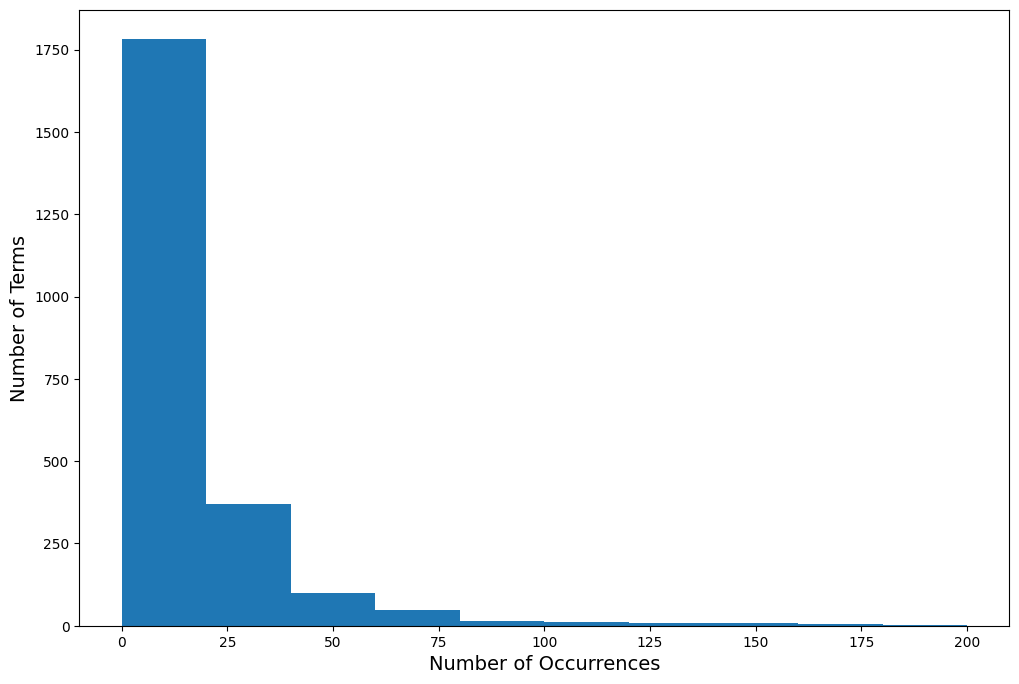

In [23]:
plt.figure(figsize = (12, 8))
plt.hist(doc_term_df.sum(axis=0).T, range=(0, 200))
plt.xlabel('Number of Occurrences',fontsize=14)
plt.ylabel('Number of Terms',fontsize=14);

In [24]:
# Re-tokenize words, recreate joined documents
corpus_df['lemmas'] = corpus_df.Text.apply(lambda x: get_lemmas(x, words_to_remove))
corpus_df['lemmas_joined'] = corpus_df.lemmas.apply(lambda x: ' '.join(x))
corpus_df.lemmas.head()

Doc_ID
226    [target, heavily, mike, banning, gerard, butle...
227    [question, linger, mind, watch, angel, fallen,...
228    [action, angel, fallen, disappointing, reason,...
229    [know, hope, angel, fallen, late, entry, popul...
230    [roman, angel, fallen, secret, service, agent,...
Name: lemmas, dtype: object

## Get Lemmatized and Filtered Sentences

Removes the additional words

In [25]:
corpus_df['sentences_lemmatized']=\
corpus_df.raw_sentences.apply(lambda x: [lemmatize_sentence(s, words_to_remove) for s in x])

In [26]:
corpus_df.head().T

Doc_ID                                                                  226  \
DSI_Title                                         RPX_Doc6_Angel_Has_Fallen   
Submission File Name                              RPX_Doc6_Angel_Has_Fallen   
Student Name                                                            RPX   
Genre of Movie                                                       Action   
Review Type (pos or neg)                                           Negative   
Movie Title                                                Angel_Has_Fallen   
Text                      Target is on the move." Heavily outnumbered an...   
Descriptor                                    Action_Angel_Has_Fallen_N_226   
Doc_ID                                                                  226   
raw_sentences             [Target is on the move.", Heavily outnumbered ...   
lemmas                    [target, heavily, mike, banning, gerard, butle...   
lemmas_joined             target heavily mike banning gerard butler exit...   
sentences_lemmatized      [target, heavily mike banning gerard butler ex...   

Doc_ID                                                                  227  \
DSI_Title                                         RPX_Doc7_Angel_Has_Fallen   
Submission File Name                              RPX_Doc7_Angel_Has_Fallen   
Student Name                                                            RPX   
Genre of Movie                                                       Action   
Review Type (pos or neg)                                           Negative   
Movie Title                                                Angel_Has_Fallen   
Text                      The only question lingering in your mind while...   
Descriptor                                    Action_Angel_Has_Fallen_N_227   
Doc_ID                                                                  227   
raw_sentences             [The only question lingering in your mind whil...   
lemmas                    [question, linger, mind, watch, angel, fallen,...   
lemmas_joined             question linger mind watch angel fallen simply...   
sentences_lemmatized      [question linger mind watch angel fallen simpl...   

Doc_ID                                                                  228  \
DSI_Title                                         RPX_Doc8_Angel_Has_Fallen   
Submission File Name                              RPX_Doc8_Angel_Has_Fallen   
Student Name                                                            RPX   
Genre of Movie                                                       Action   
Review Type (pos or neg)                                           Negative   
Movie Title                                                Angel_Has_Fallen   
Text                      The sleepy, dopey action bonanza "Angel Has Fa...   
Descriptor                                    Action_Angel_Has_Fallen_N_228   
Doc_ID                                                                  228   
raw_sentences             [The sleepy, dopey action bonanza "Angel Has F...   
lemmas                    [action, angel, fallen, disappointing, reason,...   
lemmas_joined             action angel fallen disappointing reason expec...   
sentences_lemmatized      [action angel fallen disappointing reason expe...   

Doc_ID                                                                  229  \
DSI_Title                                         RPX_Doc9_Angel_Has_Fallen   
Submission File Name                              RPX_Doc9_Angel_Has_Fallen   
Student Name                                                            RPX   
Genre of Movie                                                       Action   
Review Type (pos or neg)                                           Negative   
Movie Title                                                Angel_Has_Fallen   
Text                      I don't know what I was hoping to get from Ang...   
Descriptor                                    A

## Review Documents By Movie Title

In [27]:
print(corpus_df['Movie Title'].unique())

['Angel_Has_Fallen' 'Inception' 'No_Time_to_Die' 'Sudden_Impact' 'Taken'
 'Taxi' 'Barbie' "Don't_Look_Up" 'Holmes_and_Watson' 'Lost_city'
 'Mean_Girls' 'Red_Notice' 'Drag_me_to_hell' 'It_Chapter_Two' 'Lamb'
 'Orphan' 'TheOthers' 'The_conjuring_2' 'Batman' 'Equilibrium'
 'Minority_Report' 'Oblivion' 'Pitch_Black']


In [28]:
movie_df = corpus_df[corpus_df['Movie Title'] == 'Oblivion'].copy()
# or
#movie_df = corpus_df[corpus_df['Movie Title'] == 'Dirty_Grandpa'].copy()
movie_df.head(3).T

Doc_ID                                                                  131  \
DSI_Title                                                 FPY_Doc1_Oblivion   
Submission File Name                                      FPY_Doc1_Oblivion   
Student Name                                                            FPY   
Genre of Movie                                                       Sci-Fi   
Review Type (pos or neg)                                           Negative   
Movie Title                                                        Oblivion   
Text                      Is it possible to miss a place you've never be...   
Descriptor                                            Sci-Fi_Oblivion_N_131   
Doc_ID                                                                  131   
raw_sentences             [Is it possible to miss a place you've never b...   
lemmas                    [possible, miss, place, time, live, jack, harp...   
lemmas_joined             possible miss place time live jack harper obli...   
sentences_lemmatized      [possible miss place, time live jack harper ob...   

Doc_ID                                                                  132  \
DSI_Title                                                 FPY_Doc2_Oblivion   
Submission File Name                                      FPY_Doc2_Oblivion   
Student Name                                                            FPY   
Genre of Movie                                                       Sci-Fi   
Review Type (pos or neg)                                           Negative   
Movie Title                                                        Oblivion   
Text                      In the opening sequence of Oblivion, the voice...   
Descriptor                                            Sci-Fi_Oblivion_N_132   
Doc_ID                                                                  132   
raw_sentences             [In the opening sequence of Oblivion, the voic...   
lemmas                    [opening, sequence, oblivion, voice, tom, crui...   
lemmas_joined             opening sequence oblivion voice tom cruise pla...   
sentences_lemmatized      [opening sequence oblivion voice tom cruise pl...   

Doc_ID                                                                  133  
DSI_Title                                                 FPY_Doc3_Oblivion  
Submission File Name                                      FPY_Doc3_Oblivion  
Student Name                                                            FPY  
Genre of Movie                                                       Sci-Fi  
Review Type (pos or neg)                                           Negative  
Movie Title                                                        Oblivion  
Text                      All style, no substance is the refrain that ra...  
Descriptor                                            Sci-Fi_Oblivion_N_133  
Doc_ID                                                                  133  
raw_sentences             [All style, no substance is the refrain that r...  
lemmas                    [style, substance, run, head, watch, writer, d...  
lemmas_joined             style substance run head watch writer director...  
sentences_lemmatized      [style substance run head watch writer directo...

## Knowledge Graph Extraction

In [29]:
corpus_text_sentences = [y for x in movie_df.raw_sentences for y in x]
example_sentence = nlp(corpus_text_sentences[5])
corpus_text_sentences[5]

"Notice how the towers and Jack's mode of transport, the bubble ship, are mainly see-through."

In [30]:
entity_pairs = [get_entities(x) for x in tqdm(corpus_text_sentences)]

100%|██████████| 212/212 [00:02<00:00, 96.43it/s]


In [31]:
entity_pairs

[['you', 'place'],
 ['Jack Harper Oblivion', ''],
 ['I', 'latest sci fi films'],
 ['where  Earth', 'alien  invasion'],
 ['comfortably  hero', 'comfortably  that'],
 ['how  towers', 'transport'],
 ['it', 'false  security'],
 ['IKEA designer', 'alien  war'],
 ['film', 'epic  visuals'],
 ['who', 'strong  performances'],
 ['problem', 'sadly  plot'],
 ['It', ''],
 ['first  2/3', 'plot'],
 ['how  we', 'invasion'],
 ['mind', 'two  conflicts'],
 ['first  conflict', 'honourable Andrea Riseborough'],
 ['they', 'drones'],
 ['he', 'past  life'],
 ['why  he', 'only  it'],
 ['they', 'only  objective'],
 ['confliction', ''],
 ['still  who', 'him'],
 ['He', ''],
 ['first football you', 'last music concert'],
 ['secret  that', 'personal  museum'],
 ['beauty', 'solitude'],
 ['Victoria', 'same  feelings'],
 ['opening  voice', 'precise Commander Jack backstory'],
 ['year', ''],
 ['Earth', ''],
 ['short  which', 'nearly  earth'],
 ['Most  humans', 'space station'],
 ['Drones', 'earth'],
 ['hibernating Olga

### Create DataFrame (Source, Target, Edge)

In [32]:
relations = [get_relation(x) for x in corpus_text_sentences]
#extract subject and object
source = [i[0] for i in entity_pairs]
target = [i[1] for i in entity_pairs]
kg_df = pd.DataFrame({'source': source, 'target': target, 'edge': relations})

### Equivalent Classes

In [33]:
# Define EC Mapping
equivalent_class_mapping = {
  'tom cruise': ['jack harper'],
  'director': ['filmmaker'],
  'lead actor': ['tom cruise'],
  'acts_in': ['stars_as', 'leads', 'is_actor']
}

# Collapse equivalence classes (EC) to unified labels
def collapse_equivalent_classes(df, ec_mapping):
  for unified, variants in ec_mapping.items():
    df['source'] = df['source'].replace(variants, unified)
    df['target'] = df['target'].replace(variants, unified)
    df['edge'] = df['edge'].replace(variants, unified)
  return df

kg_df = collapse_equivalent_classes(kg_df, equivalent_class_mapping)

### Knowledge Graph Preprocessing (Lowercase, Remove Empty Spaces)

In [34]:
# Move everything to lower case
kg_df.source = kg_df.source.str.lower()
kg_df.target = kg_df.target.str.lower()
kg_df.edge = kg_df.edge.str.lower()

# Filter out empties
kg_df = kg_df[kg_df.source != '']
kg_df = kg_df[kg_df.target != '']
kg_df = kg_df[kg_df.edge != ''].copy()

In [35]:
kg_df.head(6).T

0                    2                3                  4  \
source    you                    i     where  earth  comfortably  hero   
target  place  latest sci fi films  alien  invasion  comfortably  that   
edge       is                   's        continues    contrasted with   

                  5                6  
source  how  towers               it  
target    transport  false  security  
edge         notice      suggests to

In [36]:
kg_df.shape

(190, 3)

In [37]:
len(corpus_text_sentences)

212

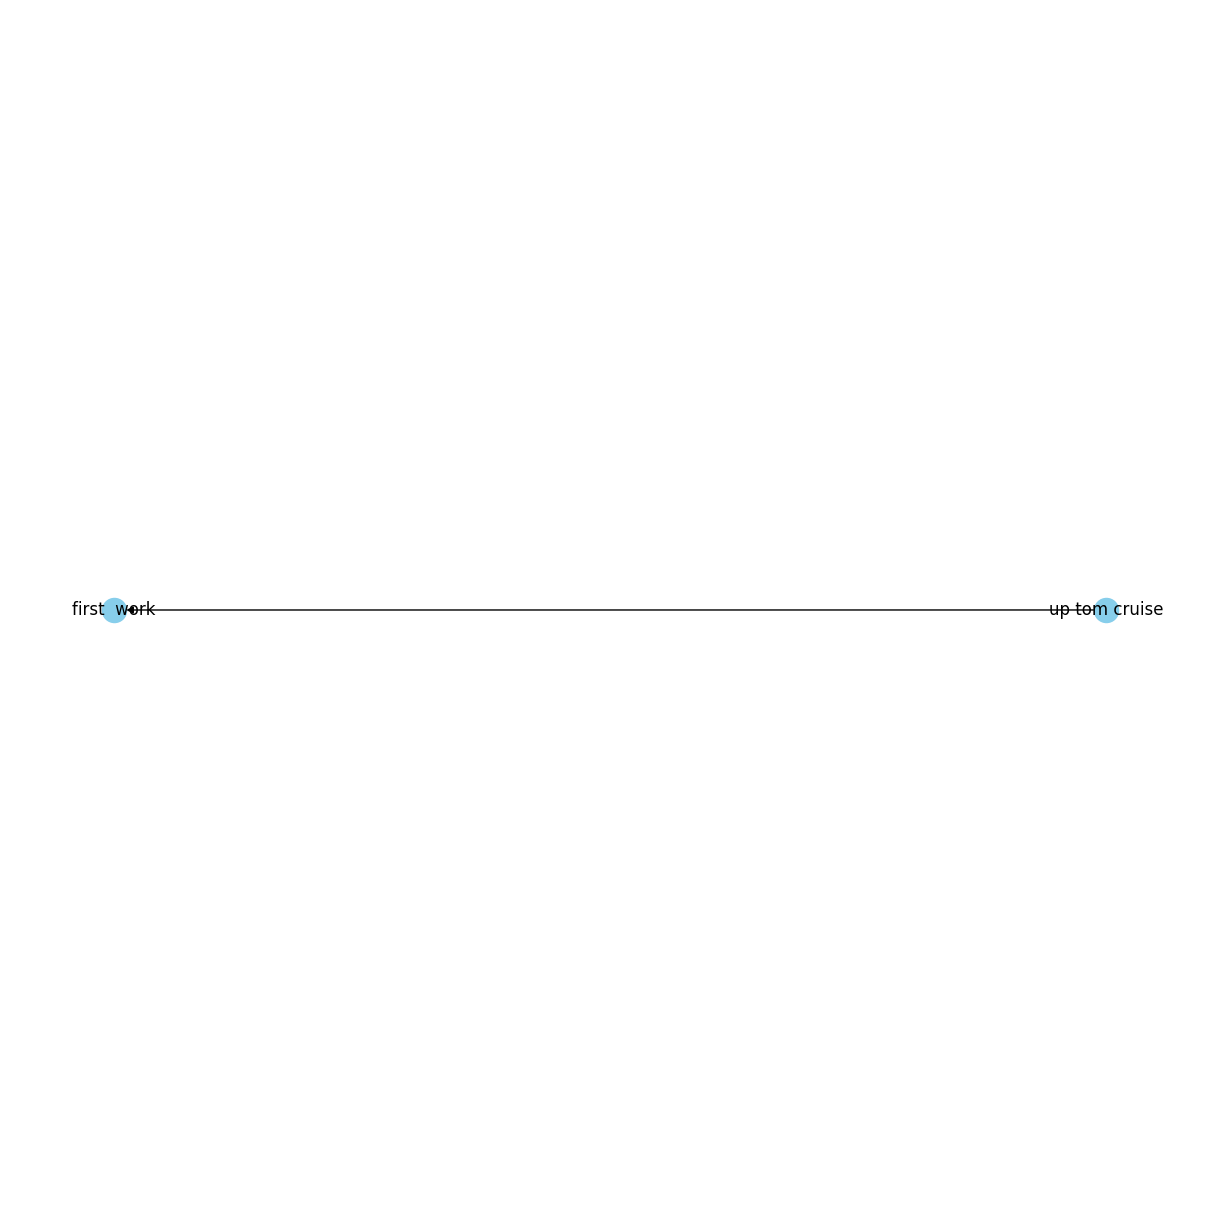

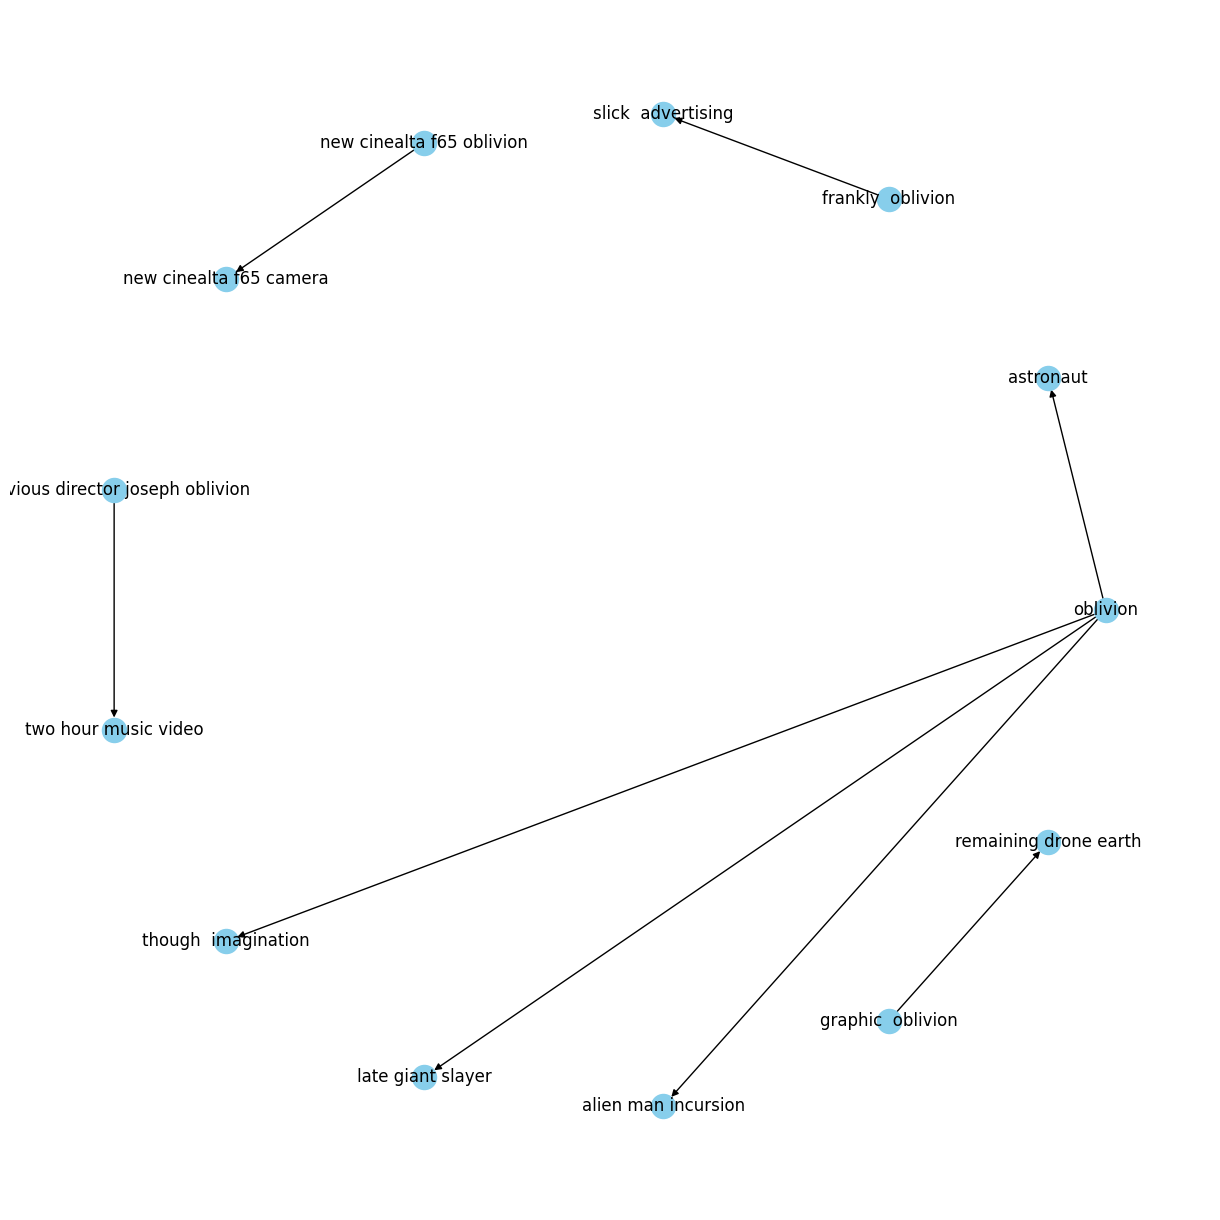

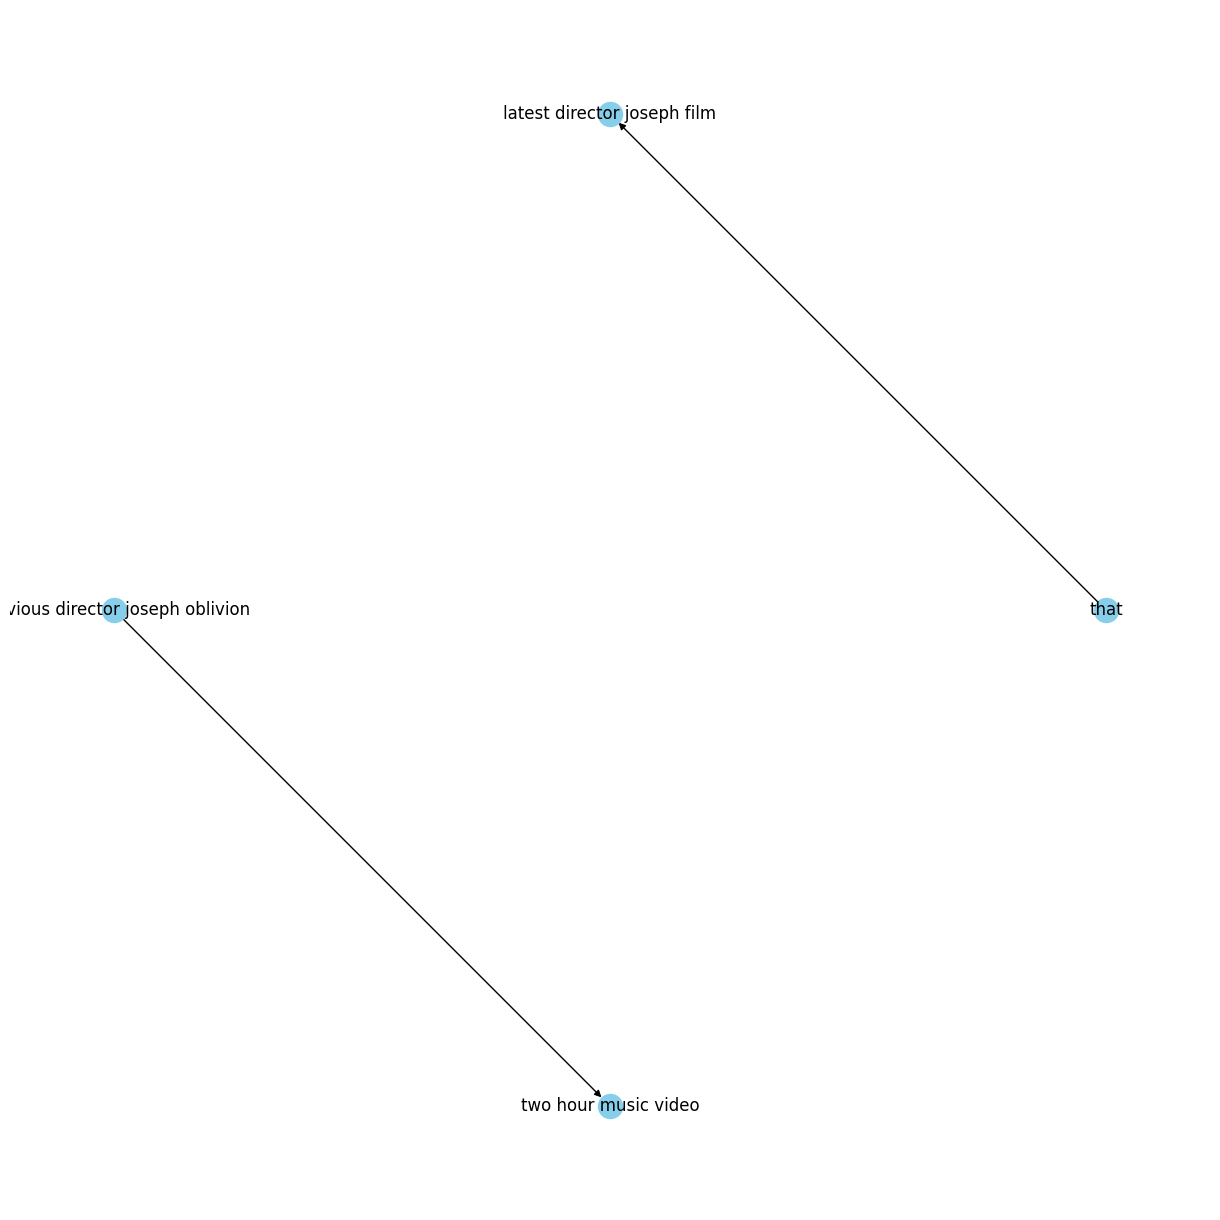

In [38]:
# plot subgraphs
def filter_kg_by_keyword(df, keywords):
    mask = df['source'].str.contains('|'.join(keywords)) | df['target'].str.contains('|'.join(keywords))
    return df[mask]

tom_cruise_subgraph = filter_kg_by_keyword(kg_df, ['tom cruise'])
oblivion_subgraph = filter_kg_by_keyword(kg_df, ['oblivion'])
director_subgraph = filter_kg_by_keyword(kg_df, ['director'])

plot_graph(tom_cruise_subgraph)

plot_graph(oblivion_subgraph)

plot_graph(director_subgraph)

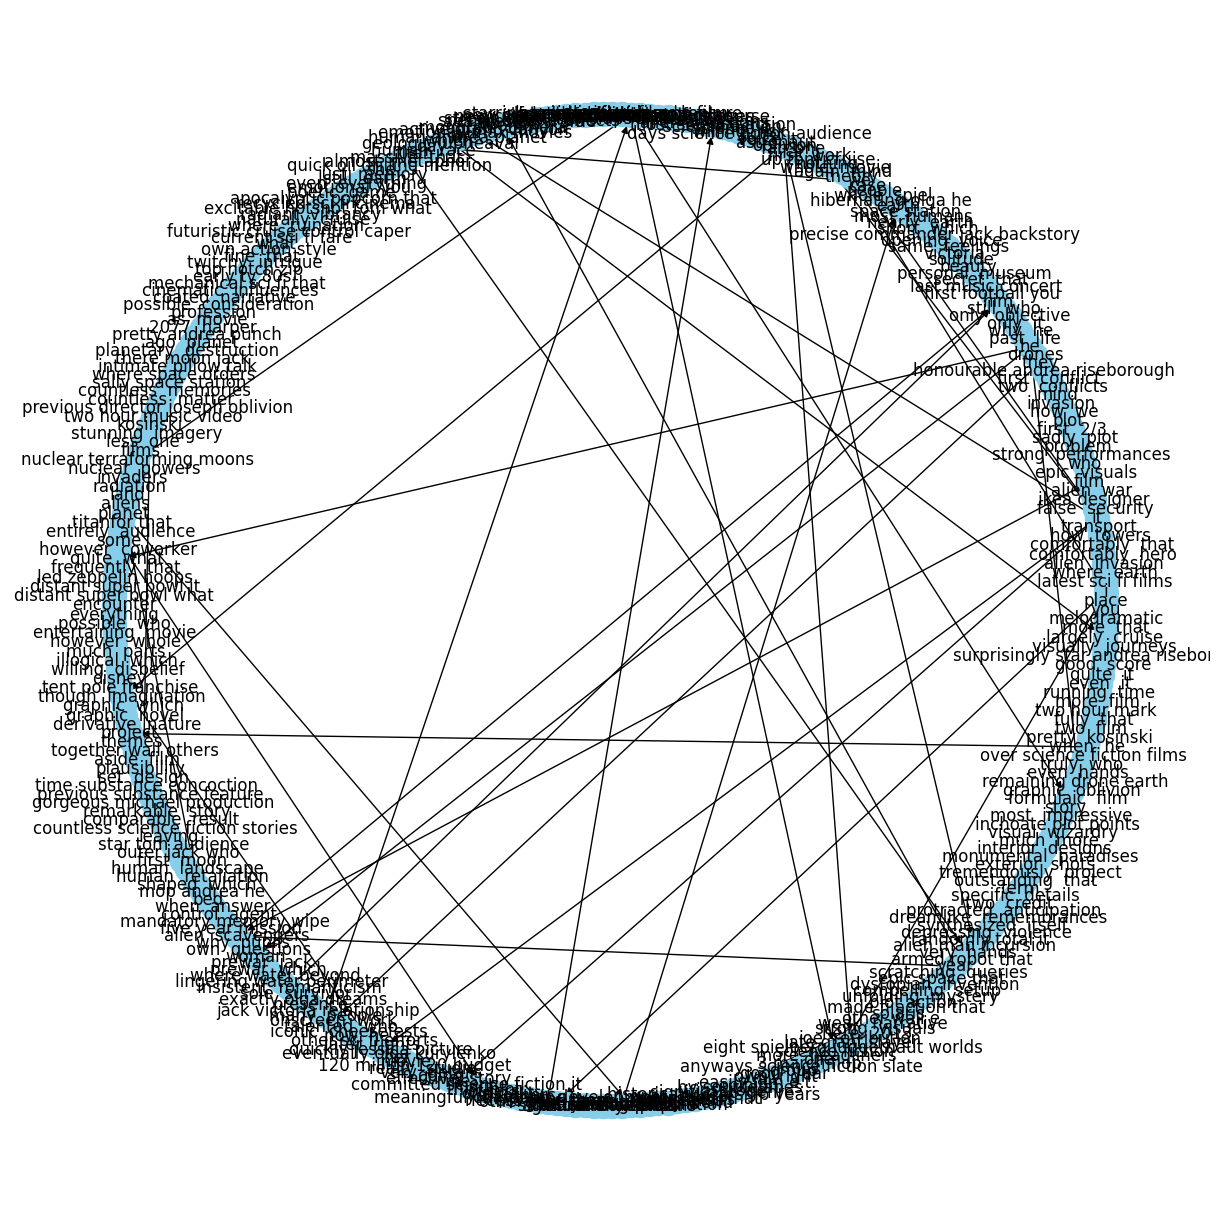

In [39]:
plot_graph(kg_df, use_circular=True)

BERT NER (Named Entity Recognition)

In [40]:
# NER Setup with BERT
def setup_ner_pipeline(model_name="dbmdz/bert-large-cased-finetuned-conll03-english"):
    """
    Set up the NER pipeline using the specified BERT model.
    """
    try:
        ner_pipeline = pipeline("ner", model=model_name, aggregation_strategy="simple")
        print("NER pipeline set up successfully.")
        return ner_pipeline
    except Exception as e:
        print(f"An error occurred while setting up the NER pipeline: {e}")
        return None

In [41]:
# Performing NER and Storing Results in DataFrames
def perform_ner_and_store_in_df(data, ner_pipeline):
    """
    Perform NER on the loaded dataset using the specified NER pipeline and store the results in DataFrames.
    The dataset should have 'title' and 'content' columns.
    """
    if data is not None and ner_pipeline is not None:
        titles = data['title']
        contents = data['content']
        df_dict = {}
        for title, text in zip(titles, contents):
            print ("Processing: ", title)
            entities = ner_pipeline(text)
            df_dict[title] = pd.DataFrame(entities)
        print("NER processing completed.")
        return df_dict
    else:
        print("Data or NER pipeline is not properly initialized.")
        return {}

In [42]:
# Set up the NER pipeline
ner_pipeline = setup_ner_pipeline()

# Make a new dataframe "data" for use with NER; copying and renaming columns
data_raw = corpus_df.rename(columns={'Movie Title': 'title', 'raw_sentences': 'content'}).copy()

Some weights of the model checkpoint at dbmdz/bert-large-cased-finetuned-conll03-english were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


NER pipeline set up successfully.


In [43]:
# TEST ON MOVIE REVIEWS FOR ONE MOVIE

# Sample title for testing

specific_title = 'Oblivion'  # Adjust this title based on your actual data
#specific_title = 'Batman'  # Adjust this title based on your actual data


# Example filtering for just one movie, can be extended with logical operators
data = data_raw.query("title == '"+ specific_title +"'").copy()
# For multiple titles, you can use or "|"
#data = data_raw.query("title == 'Movie Title 1' | title == 'Movie Title 2'").copy()

In [44]:
# OR IF YOU WANT TO DO NER FOR ALL MOVIE REVIEWS, uncomment this line:
#data= data_raw

In [45]:
# Perform NER on the dataset and store results in DataFrame
# This can take some time.
df_dict = perform_ner_and_store_in_df(data, ner_pipeline)

Processing:  Oblivion
Processing:  Oblivion
Processing:  Oblivion
Processing:  Oblivion
Processing:  Oblivion
Processing:  Oblivion
Processing:  Oblivion
Processing:  Oblivion
Processing:  Oblivion
Processing:  Oblivion
NER processing completed.


In [46]:
# Print all document titles in the NER resutls
df_dict.keys()

dict_keys(['Oblivion'])

In [47]:
# How the returned extracted data is represented...

# Raw form:
#df_dict
#print("========")

row_at_index_0 = df_dict['Oblivion'].iloc[0]
#row_at_index_0 = df_dict['Batman'].iloc[0]
print(row_at_index_0)
print("========")

# print(df_dict['Batman'].iloc[0,0])
# print(df_dict['Batman'].iloc[1,0])
# print(df_dict['Batman'].iloc[2,0])

print(df_dict['Oblivion'].iloc[0,0])
print(df_dict['Oblivion'].iloc[1,0])
print(df_dict['Oblivion'].iloc[2,0])

0    {'entity_group': 'MISC', 'score': 0.8115792, '...
1    {'entity_group': 'MISC', 'score': 0.8413749, '...
2                                                 None
3                                                 None
4                                                 None
Name: 0, dtype: object
{'entity_group': 'MISC', 'score': 0.8115792, 'word': 'IMAX', 'start': 70, 'end': 74}
{'entity_group': 'MISC', 'score': 0.7561269, 'word': 'Oblivion', 'start': 59, 'end': 67}
{'entity_group': 'LOC', 'score': 0.958524, 'word': 'Earth', 'start': 4, 'end': 9}


In [48]:
# Access and print the NER results DataFrame for a specific title

# Check if the specific title exists in the dictionary
if specific_title in df_dict:
    # Access the DataFrame for the specific title
    df_iter = df_dict[specific_title]

    # Initialize an empty list to collect all words (entities)
    all_entities = []

    # Iterate through each row of the DataFrame
    for index, row in df_iter.iterrows():
        # Iterate through each cell in the row
        for cell in row:
            # Check if the cell contains a dictionary and has the expected keys
            if isinstance(cell, dict) and {'entity_group', 'score', 'word', 'start', 'end'}.issubset(cell):
                # Extract entity information from the dictionary
                entity_group = cell['entity_group']
                score = cell['score']
                word = cell['word']
                start = cell['start']
                end = cell['end']

                # Collect the entity details
                all_entities.append({
                    "Entity": word,
                    "Type": entity_group,
                    "Score": score,
                    "Start": start,
                    "End": end
                })

                # Example: Print out the entity information
                print(f"Entity: {word}, Type: {entity_group}, Score: {score}, Start: {start}, End: {end}")

    # If you want to do something with all_entities later, it's available
else:
    print("Title not found in the results.")


Entity: IMAX, Type: MISC, Score: 0.8115792274475098, Start: 70, End: 74
Entity: Oblivion, Type: MISC, Score: 0.8413748741149902, Start: 133, End: 141
Entity: Oblivion, Type: MISC, Score: 0.756126880645752, Start: 59, End: 67
Entity: Tom Cruise, Type: PER, Score: 0.9993877410888672, Start: 72, End: 82
Entity: Earth, Type: LOC, Score: 0.9898107051849365, Start: 139, End: 144
Entity: Earth, Type: LOC, Score: 0.9585239887237549, Start: 4, End: 9
Entity: Scav, Type: MISC, Score: 0.6085887551307678, Start: 76, End: 80
Entity: Earth, Type: LOC, Score: 0.9757944345474243, Start: 118, End: 123
Entity: Cruise, Type: ORG, Score: 0.5405722856521606, Start: 124, End: 130
Entity: Jack Harper, Type: PER, Score: 0.9992272853851318, Start: 133, End: 144
Entity: Oblivion, Type: MISC, Score: 0.8440865874290466, Start: 0, End: 8
Entity: Cruise, Type: PER, Score: 0.9990971088409424, Start: 221, End: 227
Entity: Joseph Kosinski, Type: PER, Score: 0.9904084801673889, Start: 9, End: 24
Entity: Tron : Legacy, 

In [49]:
# TRANSFER WORDS FROM NER DATA-STRUCTURE TO A SIMPLE LIST

# Initialize an empty list to collect all the "word" values
all_entities = []

# Iterate through each row in the DataFrame
for index, row in df_dict['Oblivion'].iterrows():
    # Iterate through each column/cell in the row
    for col in row.index:
        # Access the cell value, which is expected to be a dictionary
        cell_value = row[col]
        # Check if the cell value is a dictionary and has the key 'word'
        if isinstance(cell_value, dict) and 'word' in cell_value:
            # Add the "word" value from the dictionary to the list
            all_entities.append(cell_value['word'])

# Now, all_words contains all the "word" values extracted from the dictionaries
print(all_entities)

['IMAX', 'Oblivion', 'Oblivion', 'Tom Cruise', 'Earth', 'Earth', 'Scav', 'Earth', 'Cruise', 'Jack Harper', 'Oblivion', 'Cruise', 'Joseph Kosinski', 'Tron : Legacy', 'Kosinski', 'Oblivion', 'Tron : Legacy', 'French', 'M83', 'Oblivion', 'Tom Cruise', 'Andrea Riseborough', 'Cruise', 'Riseborough', 'Olga Kurylenko']


In [50]:
# Find the lowercased words of all
all_entities= [word.lower() for word in all_entities]

entities_kg_df= find_sources_and_targets_with_patterns(all_entities, kg_df)

In [51]:
all_entities

['imax',
 'oblivion',
 'oblivion',
 'tom cruise',
 'earth',
 'earth',
 'scav',
 'earth',
 'cruise',
 'jack harper',
 'oblivion',
 'cruise',
 'joseph kosinski',
 'tron : legacy',
 'kosinski',
 'oblivion',
 'tron : legacy',
 'french',
 'm83',
 'oblivion',
 'tom cruise',
 'andrea riseborough',
 'cruise',
 'riseborough',
 'olga kurylenko']

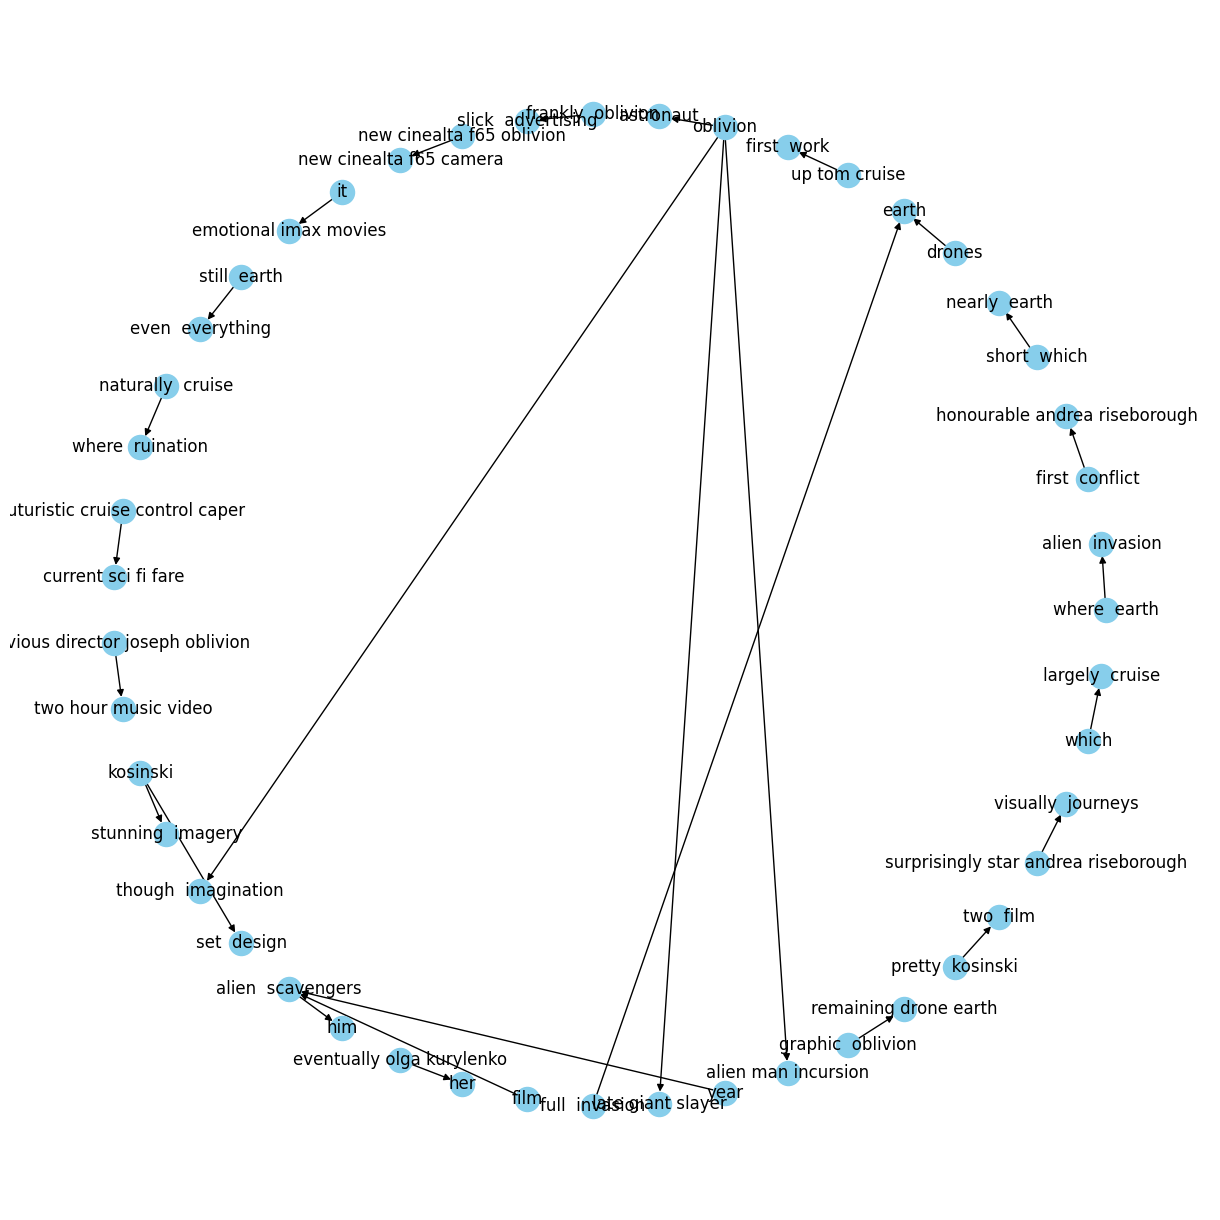

In [52]:
plot_graph(entities_kg_df, use_circular=True)

##BEGIN EXPERIMENTAL CODE


In [53]:
# I sometimes export the knowledge data-frames to Excel. I have found it useful to examine the results
# and hand edit the results and import them back for the semi-automated construction of the knowledge graph.

In [54]:
# kg_df.to_excel("kg.xlsx")

OpenAI extracts Entities

In [55]:
# If you want to try it, you'll need an account with OpenAI to use this experimental code.
# I spent under a dollar working on it as it's not expensive, but watch your spending, and set limit!
# Remember, the OpenAI API isn't free!
#
# Get API Key here:   https://platform.openai.com/account/api-keys
# Monitor usage:      https://platform.openai.com/account/usage
# Set usage limits:   https://platform.openai.com/account/billing/limits
#
# (Put your OpenAI key in the function parse_sentences_openai( ) .)
# I developed it in the starter code notebook and removed the extraneous cells so you can see what's new.

# There's basically two functions
#   (1) parse_sentences_openai( ) which makes the OpenAI API calls
#   (2) parse_openai_response( ) which takes the OpenAI API output and tries to put them
#         into a knowledge graph data-frame called global_kg_df2 .

In [56]:
!pip install openai

In [57]:
import nltk
import pandas as pd
import re
from nltk.tokenize import sent_tokenize
import re
from io import StringIO
import openai
import time

nltk.download('punkt_tab')

def parse_openai_response(response):
    print ("Response: ", response, "\n")
    try:  # Parsing might blow up
      # Check the style of the output and parse accordingly
      if "Subject: " in response and "Verb: " in response and "Object: " in response:
          if " - " in response:
              chunks = response.strip().split("\n\n")
              subjects, verbs, objects = [], [], []
              for chunk in chunks:
                  subject = re.search('Subject: (.*)', chunk)
                  verb = re.search('Verb: (.*)', chunk)
                  obj = re.search('Object: (.*)', chunk)
                  if subject: subjects.append(subject.group(1).strip())
                  if verb: verbs.append(verb.group(1).strip())
                  if obj: objects.append(obj.group(1).strip())
          else:
              lines = response.strip().split("\n")
              subjects, verbs, objects = [], [], []
              for line in lines:
                  subject = re.search('Subject: (.*?);', line)
                  verb = re.search('Verb: (.*?);', line)
                  obj = re.search('Object: (.*)', line)
                  if subject: subjects.append(subject.group(1))
                  if verb: verbs.append(verb.group(1))
                  if obj: objects.append(obj.group(1))
      elif "(" in response and ")" in response:
          lines = response.strip().split("\n")
          subjects, verbs, objects = [], [], []
          for line in lines:
              match = re.search('\((.*); (.*); (.*)\)', line)
              if match:
                  subjects.append(match.group(1).strip())
                  verbs.append(match.group(2).strip())
                  objects.append(match.group(3).strip())
      elif ";" in response:
          # Remove the leading numbers and period from each line
          response = re.sub(r'\d+\.', '', response)

          # Use StringIO to convert the string to a file-like object for use with pandas
          data = StringIO(response)

          # Read the data into a pandas DataFrame, specifying the separator and column names
          df = pd.read_csv(data, sep=';', names=['source', 'edge', 'target'])

          # Strip leading/trailing whitespace from each cell in the DataFrame
          df = df.applymap(lambda x: x.strip() if isinstance(x, str) else x)
          return df  # THERE ARE TWO RETURNS HERE. SHOULD CLEAN THIS UP IN THE FUTURE.

      else:
          subjects, verbs, objects = [], [], []
          # raise ValueError("Unknown response format.")
    except:
      print ("Parsing ran into an error. Recovering.")
      subjects, verbs, objects = [], [], []

    try:
      return_df= pd.DataFrame({'source': subjects, 'edge': verbs, 'target': objects})
    except:
      subjects, verbs, objects = [], [], []
      return_df= pd.DataFrame({'source': subjects, 'edge': verbs, 'target': objects})

    #return pd.DataFrame({'subject': subjects, 'verb': verbs, 'object': objects})
    return return_df  # THERE ARE TWO RETURNS HERE. SHOULD CLEAN THIS UP IN THE FUTURE.


def parse_sentences_openai(sentences, restart=0):
    global global_kg_df2  # Use the global DataFrame

    openai.api_key = 'OPENAI_KEY'
    for i in range(restart, len(sentences)):
        sentence = sentences[i]
        print(f"Processing sentence {i}: {sentence}\n")
        messages = [
            {"role": "system", "content": "You are a helpful assistant that can extract separate tuples from English sentences of any complexity. The tuple should be in the form of (Subject; Verb; Object). Don't number the tuples. Dereference pronouns."},
            {"role": "user", "content": sentence}
        ]
        response = openai.chat.completions.create(
            model="gpt-3.5-turbo",
            max_tokens=300,
            temperature=0,
            messages=messages
        )
        sentence_df = parse_openai_response(response.choices[0].message.content)
        global_kg_df2 = pd.concat([global_kg_df2, sentence_df], ignore_index=True)
        print ("From this sentence: ", len(sentence_df.index))
        print ("Running total: ", len(global_kg_df2.index), "\n")
        if (len(sentence_df.index)==0):
            print ("NOTHING PARSED!")
        time.sleep(10)   # I added a delay to avoid overwhelming the OpenAI servers. After I launched
                         # this OpenAI code, I would do some chores and check back if it completed
                         # or died. A 10 second delay may be excessive, so feel free to adjust
                         # accordingly to your tastes and risk tolerance.
    return global_kg_df2




[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [58]:
# Define a global DataFrame
global_kg_df2 = pd.DataFrame(columns=['source', 'edge', 'target'])

# Define EC Mapping
equivalent_class_mapping = {
  'tom cruise': ['jack harper'],
  'director': ['filmmaker'],
  'lead actor': ['tom cruise'],
  'acts_in': ['stars_as', 'leads', 'is_actor']
}

# Collapse equivalence classes (EC) to unified labels
def collapse_equivalent_classes(df, ec_mapping):
  for unified, variants in ec_mapping.items():
    df['source'] = df['source'].replace(variants, unified)
    df['target'] = df['target'].replace(variants, unified)
    df['edge'] = df['edge'].replace(variants, unified)
  return df

global_kg_df2 = collapse_equivalent_classes(global_kg_df2, equivalent_class_mapping)

In [59]:
# If you want to experiment only at 5 sentences at first, you can specify a slice of the corpus_text_sentences array
# like:
#
# parse_sentences_openai(corpus_text_sentences[:5],  0) # Work only on the first 5 sentences of the corpus

# Once you feel comfortable with it and want to try to run it across the whole corpus, run it without a slice like:
#

parse_sentences_openai(corpus_text_sentences,  0) # Restart at sentence #0 or other sentence number, if you need to restart after OpenAI failure


# In other words, I have found that the OpenAI calls sometimes fail or hang due to load and I need to restart the
# parsing process again. I just look at the output to see what sentence it broke at.
# Suppose it broke at sentence 30, then I can rerun parse_sentences_openai( ) with:
#
# parse_sentences_openai (corpus_text_sentences,  30)
#
# and it'll continue adding to the knowledge graph data-frame global_kg_df2 where it left off.

Processing sentence 0: Is it possible to miss a place you've never been?

Response:  (You; miss; place) 

From this sentence:  1
Running total:  1 

Processing sentence 1: To mourn a time you never lived?"  Jack Harper Oblivion is a visually stunning film.

Response:  1. (Jack Harper; is; protagonist of Oblivion)
2. (film; is; visually stunning) 

From this sentence:  2
Running total:  3 

Processing sentence 2: It's what I've come to expect with the latest sci-fi films.

Response:  ( I; expect; what ) 

From this sentence:  1
Running total:  4 

Processing sentence 3: Director Joseph Kosinski continues to bring his strong visual principles from Tron Legacy (a film which I'm a massive fan of) into Oblivion, where Earth is presented as a desolate planet, destroyed by an alien invasion.

Response:  (Joseph Kosinski; continues to bring; strong visual principles)
(Joseph Kosinski; brings; strong visual principles)
(Earth; is presented as; desolate planet)
(Earth; destroyed by; alien invasi

source                edge  \
0                      You                miss   
1              Jack Harper                  is   
2                     film                  is   
3                        I              expect   
4          Joseph Kosinski  continues to bring   
..                     ...                 ...   
537  The film's first half          focuses on   
538                     It              is not   
539               The film    spirals downward   
540                a story                goes   
541                    You                want   

                                                target  
0                                                place  
1                              protagonist of Oblivion  
2                                    visually stunning  
3                                                 what  
4                             strong visual principles  
..                                                 ...  
537                             Cruise and Riseborough  
538                             Olga Kurylenko's fault  
539  when she arrives on the scene contained within...  
540  from haunting and hypnotic to melodramatic and...  
541                                           to check  

[542 rows x 3 columns]

In [60]:
global_kg_df2.shape

(542, 3)

In [61]:
# For manual review or editing of the dataframes
global_kg_df2.to_excel("kg2.xlsx")

In [62]:
print(global_kg_df2)

                    source                edge  \
0                      You                miss   
1              Jack Harper                  is   
2                     film                  is   
3                        I              expect   
4          Joseph Kosinski  continues to bring   
..                     ...                 ...   
537  The film's first half          focuses on   
538                     It              is not   
539               The film    spirals downward   
540                a story                goes   
541                    You                want   

                                                target  
0                                                place  
1                              protagonist of Oblivion  
2                                    visually stunning  
3                                                 what  
4                             strong visual principles  
..                                                 ...  


In [63]:
# Move everything to lower case
global_kg_df2.source = global_kg_df2.source.str.lower()
global_kg_df2.target = global_kg_df2.target.str.lower()
global_kg_df2.edge = global_kg_df2.edge.str.lower()

# Filter out empties
global_kg_df2 = global_kg_df2[global_kg_df2.source != '']
global_kg_df2 = global_kg_df2[global_kg_df2.target != '']
global_kg_df2 = global_kg_df2[global_kg_df2.edge != ''].copy()

# Filter out empties
global_kg_df2 = global_kg_df2[global_kg_df2.source != 'NaN']
global_kg_df2 = global_kg_df2[global_kg_df2.target != 'NaN']
global_kg_df2 = global_kg_df2[global_kg_df2.edge != 'NaN'].copy()

In [64]:
print(global_kg_df2)

                    source                edge  \
0                      you                miss   
1              jack harper                  is   
2                     film                  is   
3                        i              expect   
4          joseph kosinski  continues to bring   
..                     ...                 ...   
537  the film's first half          focuses on   
538                     it              is not   
539               the film    spirals downward   
540                a story                goes   
541                    you                want   

                                                target  
0                                                place  
1                              protagonist of oblivion  
2                                    visually stunning  
3                                                 what  
4                             strong visual principles  
..                                                 ...  


In [65]:
global_kg_df2.shape

(540, 3)

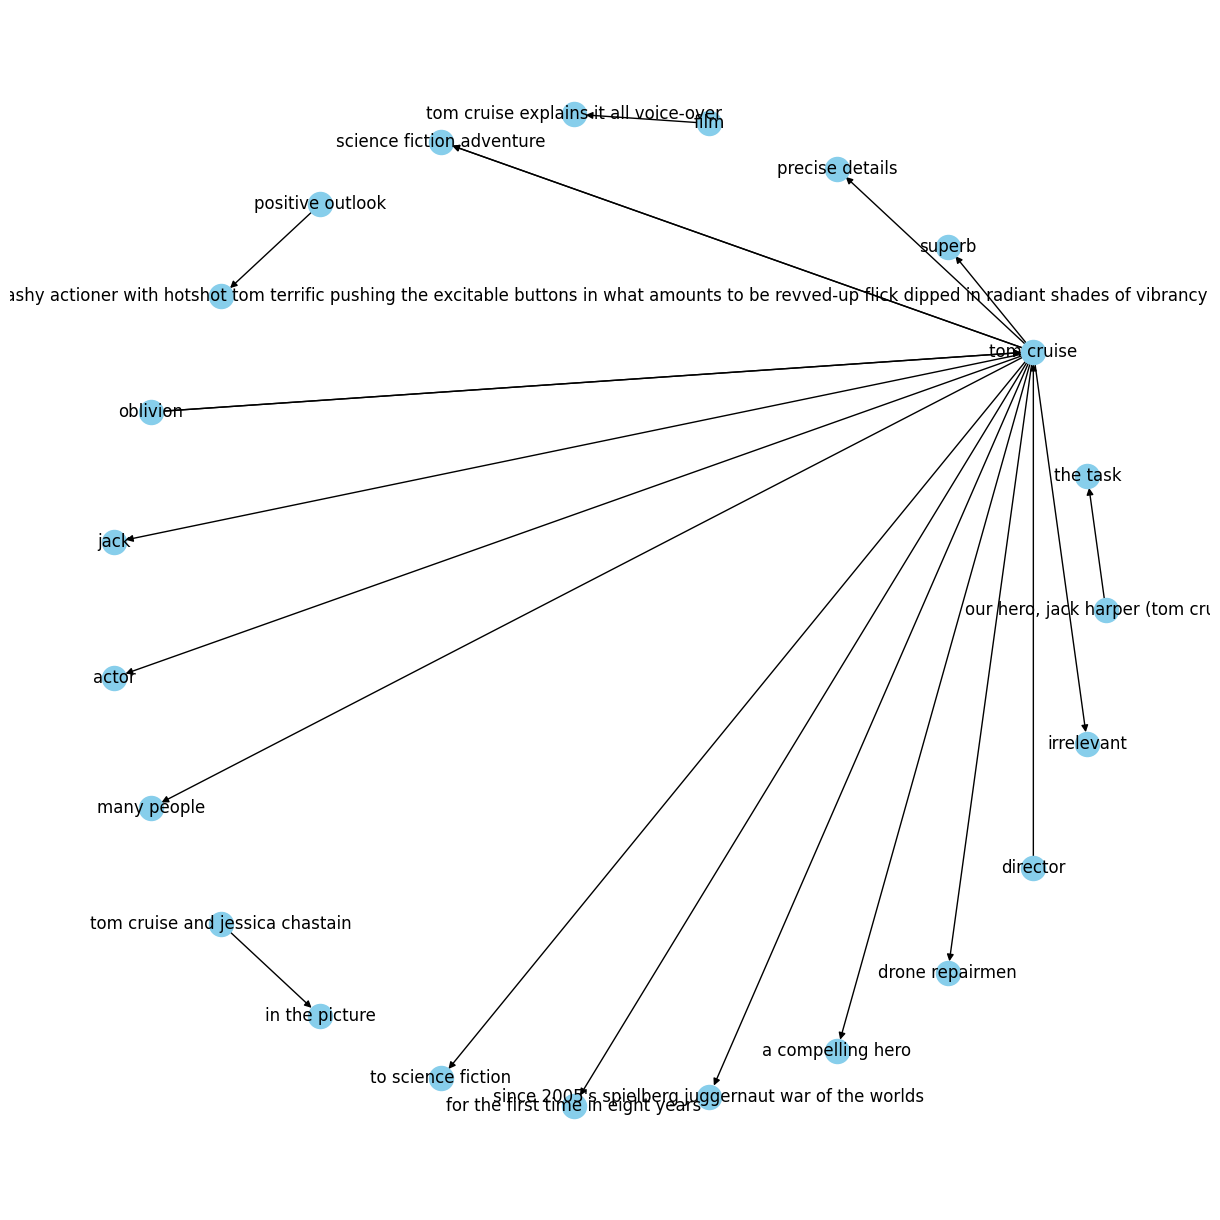

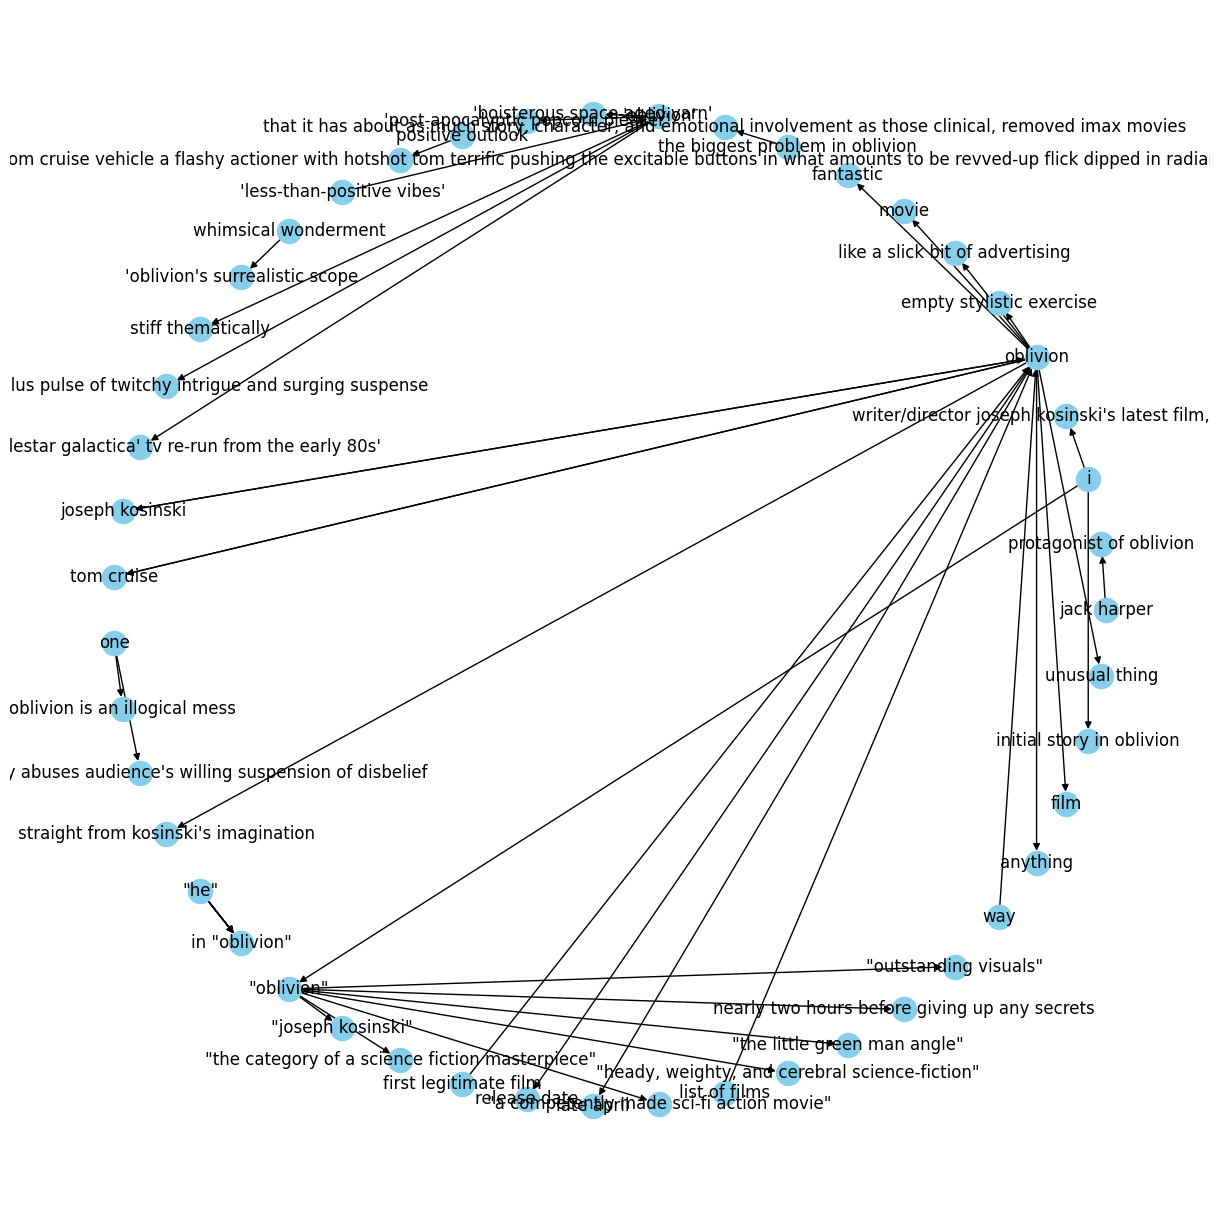

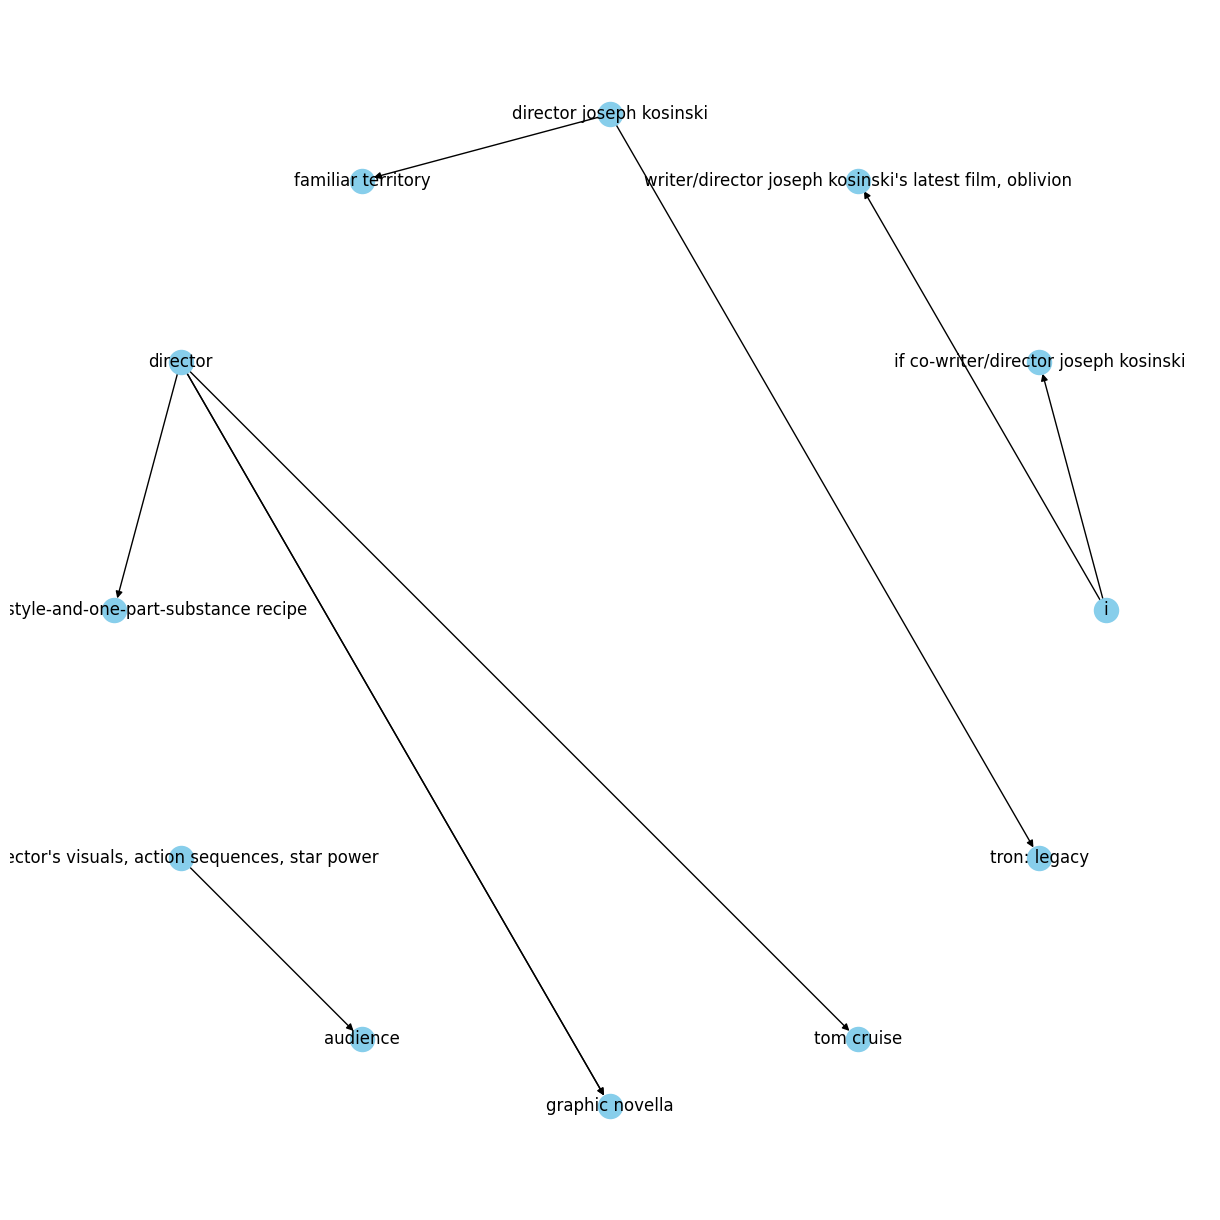

In [66]:
# plot subgraphs
def filter_kg_by_keyword(df, keywords):
    mask = df['source'].str.contains('|'.join(keywords)) | df['target'].str.contains('|'.join(keywords))
    return df[mask]

tom_cruise_subgraph = filter_kg_by_keyword(global_kg_df2, ['tom cruise'])
oblivion_subgraph = filter_kg_by_keyword(global_kg_df2, ['oblivion'])
director_subgraph = filter_kg_by_keyword(global_kg_df2, ['director'])

plot_graph(tom_cruise_subgraph)

plot_graph(oblivion_subgraph)

plot_graph(director_subgraph)

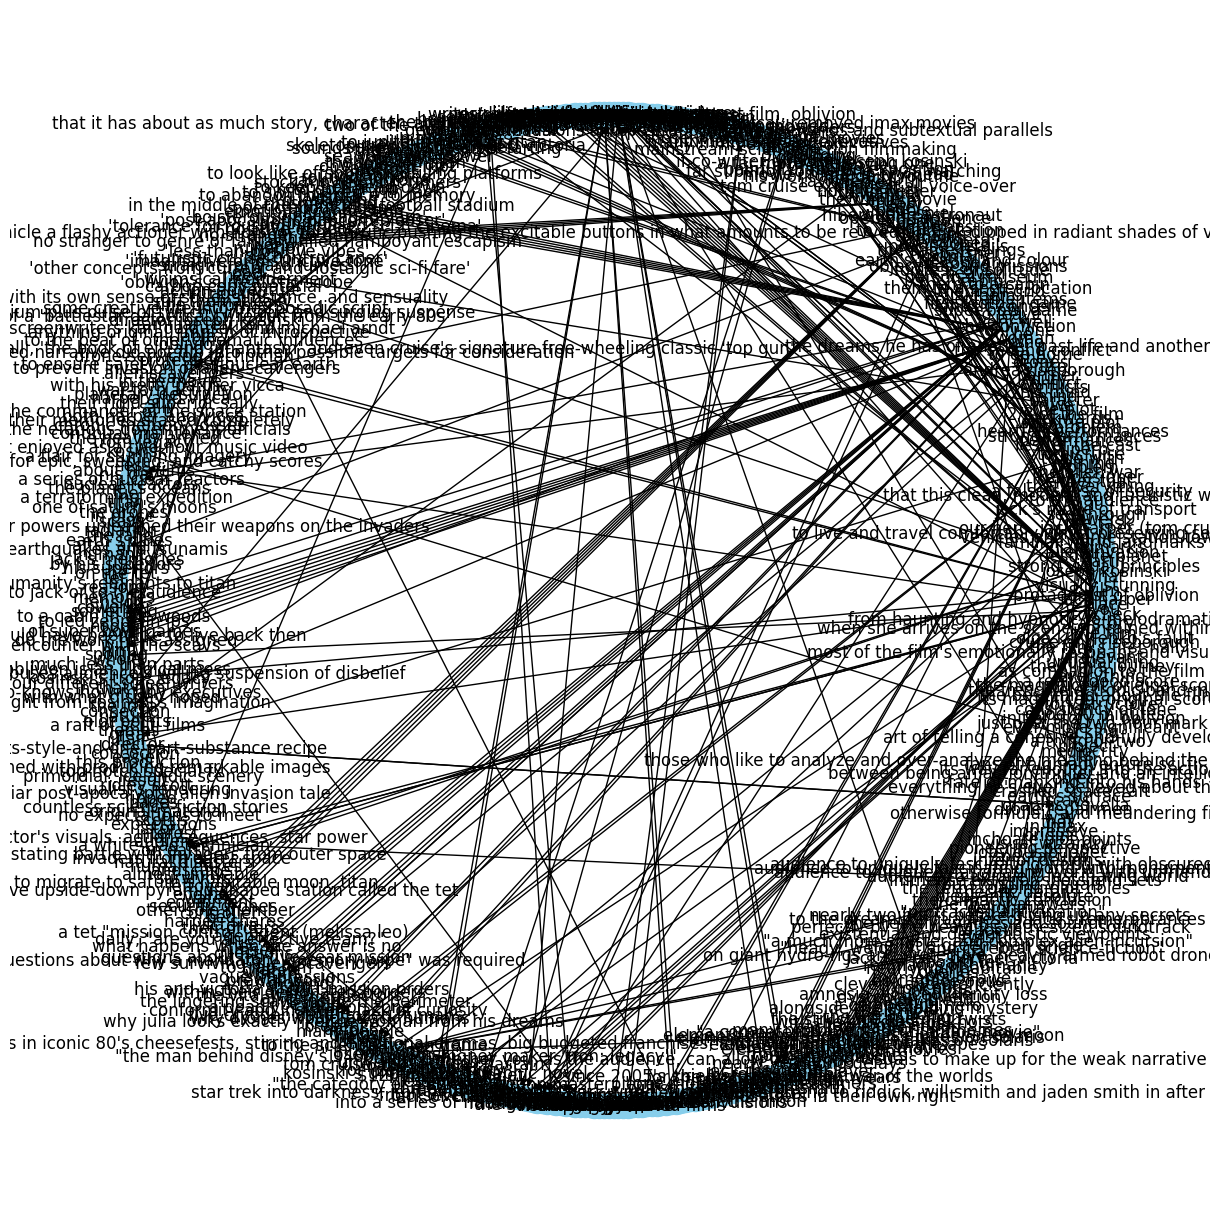

In [67]:
plot_graph(global_kg_df2, use_circular=True)

END EXPERIMENTAL CODE

## Recurrent Neural Network (RNN) Model Development

<img src="https://github.com/djp840/MSDS_453_Public/blob/main/images/BidirectionalRNN.png?raw=true">

<div class="alert alert-block alert-info">
    <b>tf.keras.layers.Bidirectional</b><br>
    https://www.tensorflow.org/api_docs/python/tf/keras/layers/Bidirectional
    </div>

In [68]:
datafull=corpus_df.copy()
datafull.reset_index(drop=True, inplace=True)
datafull.head(4).T

0  \
DSI_Title                                         RPX_Doc6_Angel_Has_Fallen   
Submission File Name                              RPX_Doc6_Angel_Has_Fallen   
Student Name                                                            RPX   
Genre of Movie                                                       Action   
Review Type (pos or neg)                                           Negative   
Movie Title                                                Angel_Has_Fallen   
Text                      Target is on the move." Heavily outnumbered an...   
Descriptor                                    Action_Angel_Has_Fallen_N_226   
Doc_ID                                                                  226   
raw_sentences             [Target is on the move.", Heavily outnumbered ...   
lemmas                    [target, heavily, mike, banning, gerard, butle...   
lemmas_joined             target heavily mike banning gerard butler exit...   
sentences_lemmatized      [target, heavily mike banning gerard butler ex...   

                                                                          1  \
DSI_Title                                         RPX_Doc7_Angel_Has_Fallen   
Submission File Name                              RPX_Doc7_Angel_Has_Fallen   
Student Name                                                            RPX   
Genre of Movie                                                       Action   
Review Type (pos or neg)                                           Negative   
Movie Title                                                Angel_Has_Fallen   
Text                      The only question lingering in your mind while...   
Descriptor                                    Action_Angel_Has_Fallen_N_227   
Doc_ID                                                                  227   
raw_sentences             [The only question lingering in your mind whil...   
lemmas                    [question, linger, mind, watch, angel, fallen,...   
lemmas_joined             question linger mind watch angel fallen simply...   
sentences_lemmatized      [question linger mind watch angel fallen simpl...   

                                                                          2  \
DSI_Title                                         RPX_Doc8_Angel_Has_Fallen   
Submission File Name                              RPX_Doc8_Angel_Has_Fallen   
Student Name                                                            RPX   
Genre of Movie                                                       Action   
Review Type (pos or neg)                                           Negative   
Movie Title                                                Angel_Has_Fallen   
Text                      The sleepy, dopey action bonanza "Angel Has Fa...   
Descriptor                                    Action_Angel_Has_Fallen_N_228   
Doc_ID                                                                  228   
raw_sentences             [The sleepy, dopey action bonanza "Angel Has F...   
lemmas                    [action, angel, fallen, disappointing, reason,...   
lemmas_joined             action angel fallen disappointing reason expec...   
sentences_lemmatized      [action angel fallen disappointing reason expe...   

                                                                          3  
DSI_Title                                         RPX_Doc9_Angel_Has_Fallen  
Submission File Name                              RPX_Doc9_Angel_Has_Fallen  
Student Name                                                            RPX  
Genre of Movie                                                       Action  
Review Type (pos or neg)                                           Negative  
Movie Title                                                Angel_Has_Fallen  
Text                      I don't know what I was hoping to get from Ang...  
Descriptor                                    Action_Angel_Has_Fallen_N_229  
Doc_ID                                             

In [69]:
datafull['Text'] = datafull['Text'].apply(lambda x :clean_doc(x))

## Preprocess DataSet

In [70]:
data = datafull[['Text','Genre of Movie']].copy()

In [71]:
data['Genre of Movie'] = data['Genre of Movie'].astype("category")
data['Genre of Movie code'] = data['Genre of Movie'].cat.codes
data['Genre of Movie code'].tail().T

225    3
226    3
227    3
228    3
229    3
Name: Genre of Movie code, dtype: int8

## Review Examples by Genre

In [72]:
features, targets = data['Text'], data['Genre of Movie code']
data[["Genre of Movie","Genre of Movie code"]].value_counts()

Genre of Movie  Genre of Movie code
Action          0                      60
Comedy          1                      60
Horror          2                      60
Sci-Fi          3                      50
Name: count, dtype: int64

## Create Datasets for Model Development

### Cell 10 - def get_dataset_partitions_pd

In [73]:
trainds, valds, testds = get_dataset_partitions_pd(data[['Text','Genre of Movie code']])
trainds.shape, valds.shape, testds.shape

((184, 2), (23, 2), (23, 2))

## Convert DataFrame to TensorFlow DataSet

In [74]:
# train X & y
train_text_ds_raw = tf.data.Dataset.from_tensor_slices(
            tf.cast(trainds['Text'].values, tf.string)
)
train_cat_ds_raw = tf.data.Dataset.from_tensor_slices(
            tf.cast(trainds['Genre of Movie code'].values, tf.int64),
  )
# test X & y
test_text_ds_raw = tf.data.Dataset.from_tensor_slices(
            tf.cast(testds['Text'].values, tf.string)
)
test_cat_ds_raw = tf.data.Dataset.from_tensor_slices(
            tf.cast(testds['Genre of Movie code'].values, tf.int64),
)
#val X & Y
val_text_ds_raw = tf.data.Dataset.from_tensor_slices(
            tf.cast(valds['Text'].values, tf.string)
)
val_cat_ds_raw = tf.data.Dataset.from_tensor_slices(
            tf.cast(valds['Genre of Movie code'].values, tf.int64),
)

## Create DataSets (X=Preprocessed Text, Y=Encoded Categories)

In [75]:
train_ds = tf.data.Dataset.zip(
    (
            train_text_ds_raw,
            train_cat_ds_raw
     )
)
test_ds = tf.data.Dataset.zip(
    (
            test_text_ds_raw,
            test_cat_ds_raw
     )
)
val_ds = tf.data.Dataset.zip(
    (
            val_text_ds_raw,
            val_cat_ds_raw
     )
)

## Create Data Pipelines (Batching, Shuffling, and Optimizing)

In [76]:
batch_size = 3
AUTOTUNE = tf.data.experimental.AUTOTUNE
buffer_size=train_ds.cardinality().numpy()

train_ds = train_ds.shuffle(buffer_size=buffer_size)\
                   .batch(batch_size=batch_size,drop_remainder=False)\
                   .cache()\
                   .prefetch(AUTOTUNE)

test_ds = test_ds.shuffle(buffer_size=buffer_size)\
                   .batch(batch_size=batch_size,drop_remainder=False)\
                   .cache()\
                   .prefetch(AUTOTUNE)


val_ds = val_ds.shuffle(buffer_size=buffer_size)\
                   .batch(batch_size=batch_size,drop_remainder=False)\
                   .cache()\
                   .prefetch(AUTOTUNE)

In [77]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230 entries, 0 to 229
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   Text                 230 non-null    object  
 1   Genre of Movie       230 non-null    category
 2   Genre of Movie code  230 non-null    int8    
dtypes: category(1), int8(1), object(1)
memory usage: 2.6+ KB


## Create the Text Encoder

The raw text loaded by `tfds` needs to be processed before it can be used in a model. The simplest way to process text for training is using the `experimental.preprocessing.TextVectorization` layer. This layer has many capabilities, but this tutorial sticks to the default behavior.

Create the layer, and pass the dataset's text to the layer's `.adapt` method:
The processing of each sample contains the following steps:

    standardize each sample (usually lowercasing + punctuation stripping)
    split each sample into substrings (usually words)
    recombine substrings into tokens (usually ngrams)
    index tokens (associate a unique int value with each token)
    transform each sample using this index, either into a vector of ints or a dense float vector.

<div class="alert alert-block alert-info">
    <b>tf.keras.layers.TextVectorization</b><br>
   https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization
    </div>

In [78]:
VOCAB_SIZE=5000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE, standardize="lower_and_strip_punctuation", pad_to_max_tokens= True)
encoder.adapt(train_ds.map(lambda text, label: text), batch_size= None)

In [79]:
vocab = np.array(encoder.get_vocabulary())
len(vocab)

5000

In [80]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 's', 'the', 'film', 'i', 'nt', 'movie', 'one', 'it',
       'like', 'time', 'character', 'get', 'even', 'make', 'first', 'but',
       'much', 'story'], dtype='<U18')

In [81]:
vocab[-20:]

array(['establishing', 'essential', 'essence', 'espionage', 'error',
       'errand', 'eric', 'eradicate', 'equipment', 'envelops', 'entity',
       'enthusiasm', 'entertained', 'enters', 'ensuring', 'ensure',
       'ensuing', 'ensues', 'enjoyment', 'englishlanguage'], dtype='<U18')

## Example of Encoded Words

In [82]:
encoded_example = encoder('encanto we dont talk about bruno no no').numpy()
encoded_example[:]

array([  1, 340,   1, 989,   1,   1, 186, 186])

In [83]:
len(encoder.get_vocabulary())

5000

In [84]:
encoder(data['Text'][0])

<tf.Tensor: shape=(326,), dtype=int64, numpy=
array([ 663,  471,  945,    1,    1,  172,  263, 1165,  457,    1, 2705,
          1,    1, 1253,    1,  997, 2745,  375, 1764,   17,  569, 1113,
          2,  724, 1639,    1, 1159,    1,  222,    2, 4415,  955,   61,
       2852,   36,  509,  114,  708,    1, 2018,  125, 1046,    2,  549,
         42,  351,  118,   65, 1228, 1381,  263,    1,  629,  309,   45,
        157,  574,  256, 1219,  907,  933, 1168,   17,  556,   53,   22,
        335,  562, 1289,  256,  344, 2118,  172,    6,  593,    2, 1283,
       1485,  391, 1878,  505,  888,  348, 2317, 4360, 4544,    1, 3328,
          6,  117,  104,  487,   57,  272, 2611, 3171, 3183, 4706,  195,
          1,   23,  413, 2860,  165, 4692, 1510, 1309, 2595,  302, 1230,
       2150,  881, 1819,  205, 1013, 2107, 2772,  754,  181,    1, 1573,
         50,  374,  263,    2,    1, 4148, 1454,  590,  461, 1057, 2754,
       3902, 4021, 1243,  875,   53,    1, 1330, 1062,  107,   43, 1609,
     

In [85]:
for example, label in train_ds.take(1):
  print('texts: ', example.numpy()[:1])
  print()

texts:  [b"Do blonde fun ? She . He n't . In Barbie Land , Barbie ( Margot Robbie ) posse ( Issa Rae , Dua Lipa , Alexandra Shipp ) run queendom . Her boy toy Ken ( Ryan Gosling ) clone ( Simu Liu , Kingsley Ben-Adir , Ncuti Gatwa , John Cena ) n't . The young woman proud president , astronaut executive . Why would n't ? They assume success witnessed girl lady real world role model worthy emulation . That 's true , part . However , unbeknownst , impossibly trim physique caused female experience body shame . Why ? Because one earth figure like Barbie . With gleam eye , writer/director Greta Gerwig explores pro con doll 's influence maker ( Mattel ) got thing wrong thing right . When Barbie start alternate thought express weird feeling Barbie manual , follower question meaning life : `` You guy ever think dying . `` Say ? The feminist script make secret ambition . Girl power bust . The humor chuckle-worthy steadily hilarious ( Joy Ride ) . The plotline ( co-writers Gerwig Noah Baumbach )

In [86]:
#

## Build RNN Sequential Model

<div class="alert alert-block alert-info">
    <b>tf.keras.layers</b><br>
    https://www.tensorflow.org/api_docs/python/tf/keras/layers
    </div>

In [87]:
# RNN Model 1 (1 layer with 32 neurons)
k.clear_session()
num_classes = 4

model_rnn = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        mask_zero=True  # Use masking to handle variable sequence lengths
    ),
    tf.keras.layers.Bidirectional(tf.keras.layers.SimpleRNN(32,dropout=0.3)),  # Replaced LSTM with SimpleRNN
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(num_classes, activation='softmax')  # num_classes = 4
])

In [88]:
model_rnn.compile(optimizer= tf.keras.optimizers.Adam( )
                 ,loss=tf.keras.losses.SparseCategoricalCrossentropy()
                 ,metrics=['accuracy'])

In [89]:
%%time
history_rnn = model_rnn.fit(train_ds
             ,epochs=200
             ,validation_data=val_ds
             #,validation_steps=3
             ,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)])


Epoch 1/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 32s 343ms/step - accuracy: 0.3151 - loss: 1.4035 - val_accuracy: 0.1739 - val_loss: 1.4617
Epoch 2/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 12s 192ms/step - accuracy: 0.5660 - loss: 1.2084 - val_accuracy: 0.3043 - val_loss: 1.3792
Epoch 3/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 20s 184ms/step - accuracy: 0.9556 - loss: 0.6368 - val_accuracy: 0.3043 - val_loss: 1.3445
Epoch 4/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 11s 174ms/step - accuracy: 1.0000 - loss: 0.1377 - val_accuracy: 0.4783 - val_loss: 1.3570
Epoch 5/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 12s 189ms/step - accuracy: 1.0000 - loss: 0.0384 - val_accuracy: 0.3913 - val_loss: 1.2893
Epoch 6/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 21s 192ms/step - accuracy: 1.0000 - loss: 0.0135 - val_accuracy: 0.4348 - val_loss: 1.3655
CPU times: user 2min 5s, sys: 1.82 s, total: 2min 7s
Wall time: 1min 55s


## Model Performance Test Accuracy - RNN

In [90]:
test_loss, test_acc = model_rnn.evaluate(test_ds)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.1708 - loss: 1.8766
Test Loss: 1.9107966423034668
Test Accuracy: 0.1304347813129425


## Plotting Performance Metrics - RNN

In [91]:
history_rnn_dict = history_rnn.history
history_rnn_dict.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [92]:
history_rnn_df=pd.DataFrame(history_rnn_dict)
history_rnn_df.tail().round(3)

accuracy   loss  val_accuracy  val_loss
1     0.690  1.138         0.304     1.379
2     0.978  0.513         0.304     1.344
3     1.000  0.117         0.478     1.357
4     1.000  0.031         0.391     1.289
5     1.000  0.012         0.435     1.365

In [93]:
losses_rnn = history_rnn.history['loss']
accs_rnn = history_rnn.history['accuracy']
val_losses_rnn = history_rnn.history['val_loss']
val_accs_rnn = history_rnn.history['val_accuracy']
epochs_rnn = len(losses_rnn)

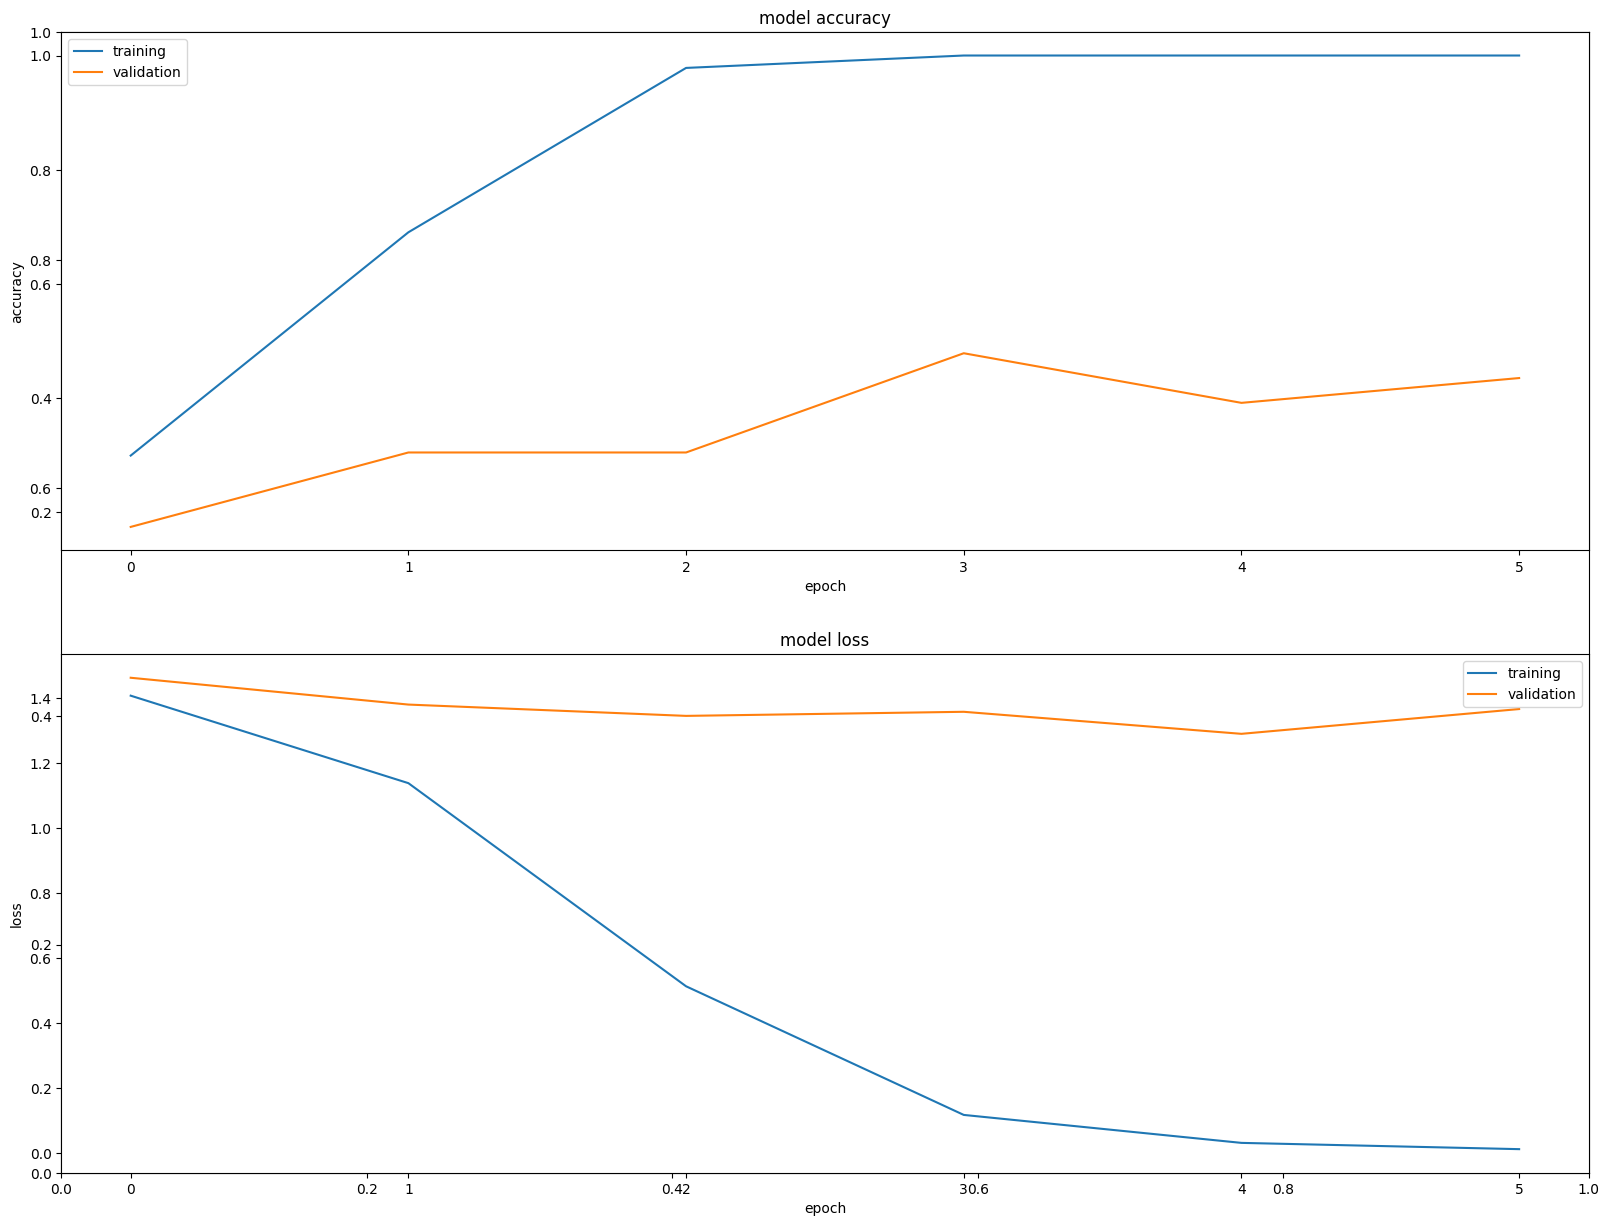

In [94]:
plt.subplots(figsize=(16,12))
plt.tight_layout()
display_training_curves(history_rnn.history['accuracy'], history_rnn.history['val_accuracy'], 'accuracy', 211)
display_training_curves(history_rnn.history['loss'], history_rnn.history['val_loss'], 'loss', 212)

## Confusion Matrix Post Model Performance Analysis - RNN

In [95]:
preds2_rnn = model_rnn.predict(test_ds)
y_pred2_rnn = np.argmax(preds2_rnn, axis=1)
y2_rnn = np.concatenate([y for x, y in test_ds], axis=0)

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step


In [96]:
CLASSES_LIST = ['Action','Comedy','Horror','Sci Fi']

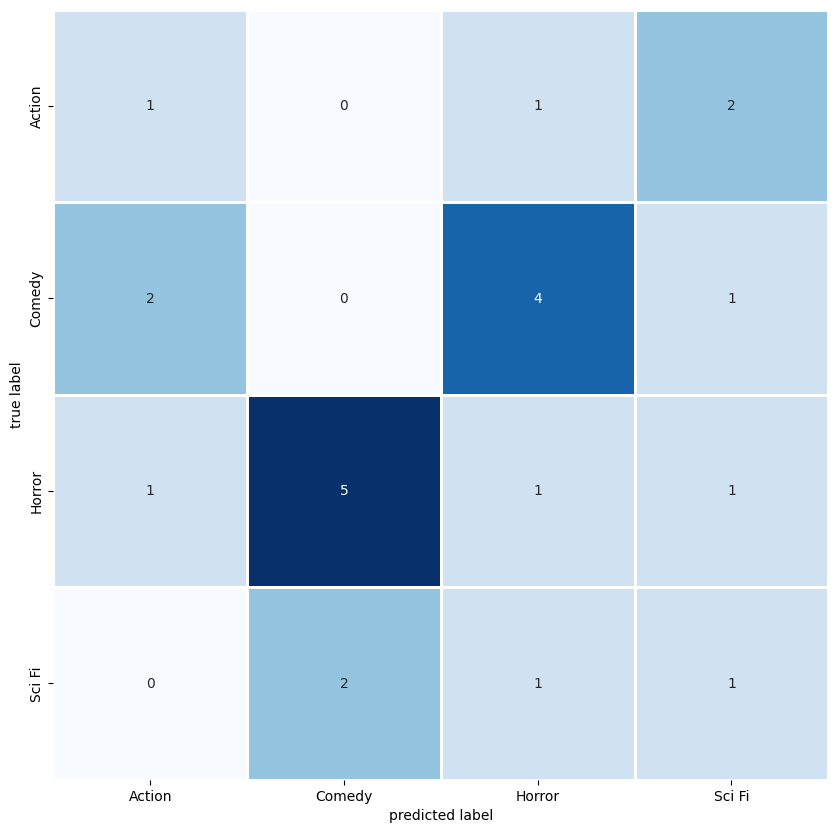

In [97]:
plot_confusion_matrix_labeled(y2_rnn,y_pred2_rnn, CLASSES_LIST=CLASSES_LIST)

In [98]:
cm = sns.light_palette((260, 75, 60), input="husl", as_cmap=True)

In [99]:
df2_rnn = pd.DataFrame(preds2_rnn[0:15]
                  ,columns = CLASSES_LIST).T
df2_rnn.style.format("{:.2%}").background_gradient(cmap=cm)

## RNN Model Architecture

In [100]:
model_rnn.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization              │ (None, None)           │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, None, 64)       │       320,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 64)             │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 991,886 (3.78 MB)

 Trainable params: 330,628 (1.26 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 661,258 (2.52 MB)

Epoch 1/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 20s 245ms/step - accuracy: 0.2456 - loss: 1.4132 - val_accuracy: 0.0870 - val_loss: 1.4807
Epoch 2/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 13s 203ms/step - accuracy: 0.6080 - loss: 1.2140 - val_accuracy: 0.3043 - val_loss: 1.4195
Epoch 3/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 12s 199ms/step - accuracy: 0.8726 - loss: 0.8697 - val_accuracy: 0.3043 - val_loss: 1.3678
Epoch 4/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 20s 200ms/step - accuracy: 0.9790 - loss: 0.3601 - val_accuracy: 0.3478 - val_loss: 1.4558
Epoch 5/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 12s 201ms/step - accuracy: 1.0000 - loss: 0.0760 - val_accuracy: 0.3478 - val_loss: 1.5920
Epoch 6/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 12s 197ms/step - accuracy: 1.0000 - loss: 0.0175 - val_accuracy: 0.3478 - val_loss: 1.6370
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.4696 - loss: 1.3011
Test Loss: 1.408157229423523
Test Accuracy: 0.3478260934352875
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step


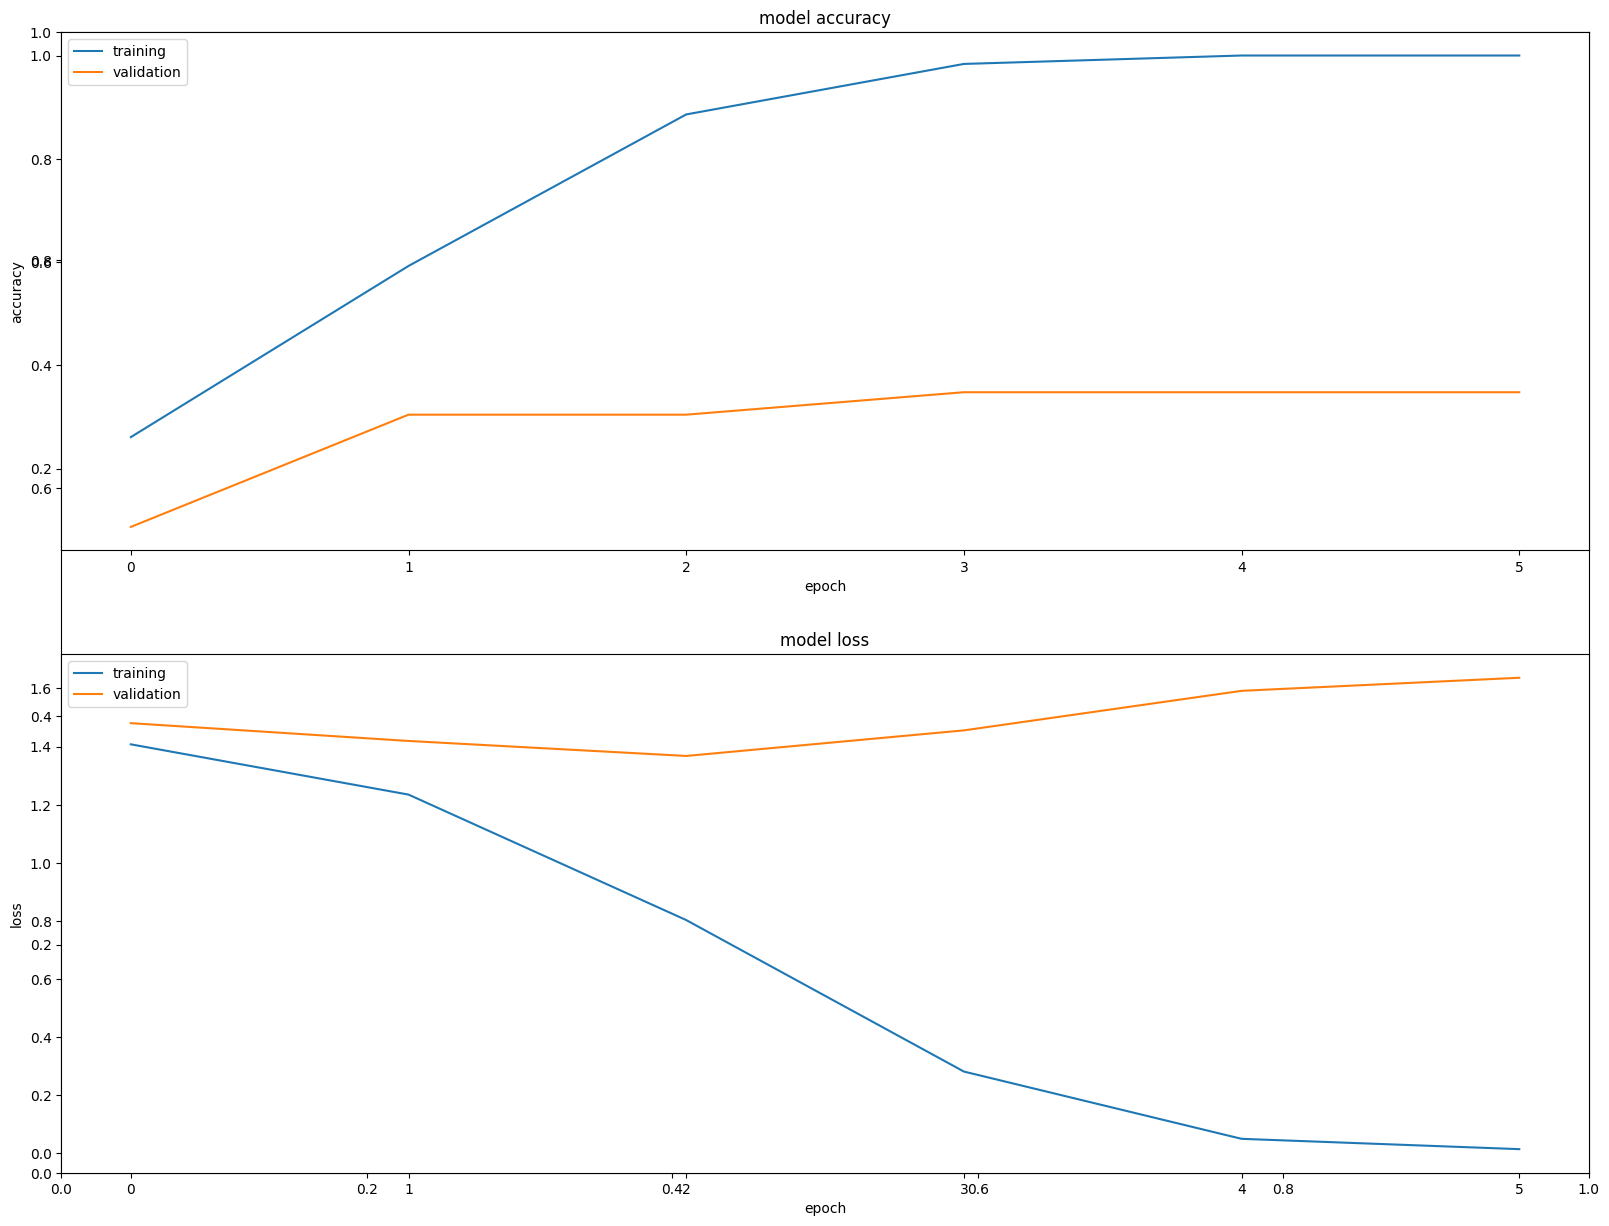

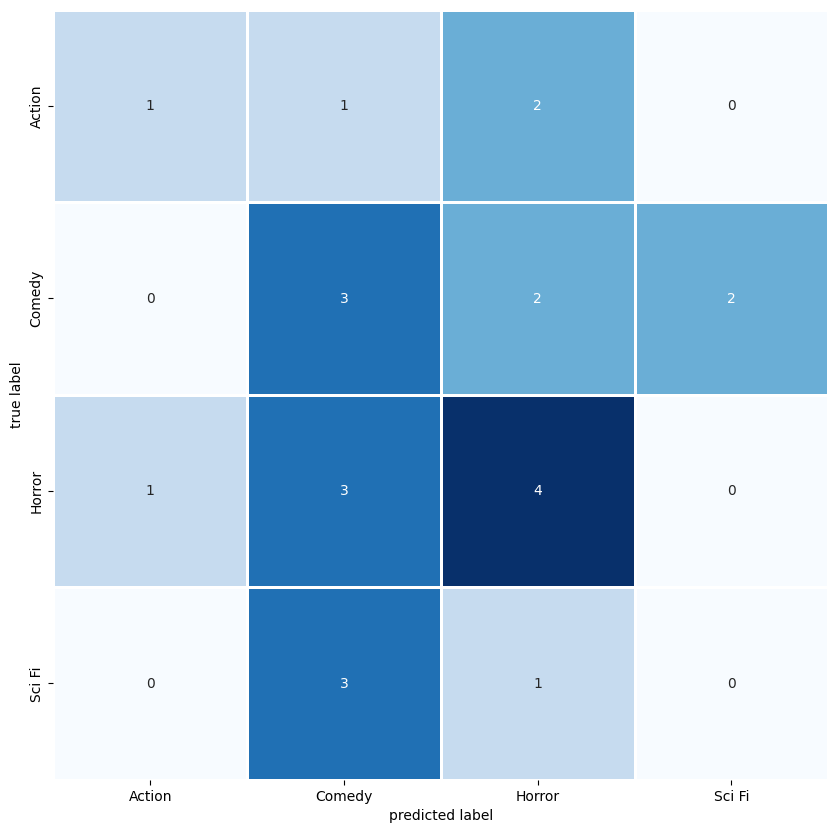

In [101]:
# RNN Model 2 (1 layer with 64 neurons)
k.clear_session()
num_classes = 4

model_rnn = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        mask_zero=True  # Use masking to handle variable sequence lengths
    ),
    tf.keras.layers.Bidirectional(tf.keras.layers.SimpleRNN(64,dropout=0.1)),  # Replaced LSTM with SimpleRNN
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(num_classes, activation='softmax')  # num_classes = 4
])

model_rnn.compile(optimizer= tf.keras.optimizers.Adam( )
                 ,loss=tf.keras.losses.SparseCategoricalCrossentropy()
                 ,metrics=['accuracy'])

history_rnn = model_rnn.fit(train_ds
             ,epochs=200
             ,validation_data=val_ds
             #,validation_steps=3
             ,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)])

test_loss, test_acc = model_rnn.evaluate(test_ds)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

history_rnn_dict = history_rnn.history
history_rnn_dict.keys()

history_rnn_df=pd.DataFrame(history_rnn_dict)
history_rnn_df.tail().round(3)

losses_rnn = history_rnn.history['loss']
accs_rnn = history_rnn.history['accuracy']
val_losses_rnn = history_rnn.history['val_loss']
val_accs_rnn = history_rnn.history['val_accuracy']
epochs_rnn = len(losses_rnn)

plt.subplots(figsize=(16,12))
plt.tight_layout()
display_training_curves(history_rnn.history['accuracy'], history_rnn.history['val_accuracy'], 'accuracy', 211)
display_training_curves(history_rnn.history['loss'], history_rnn.history['val_loss'], 'loss', 212)

preds2_rnn = model_rnn.predict(test_ds)
y_pred2_rnn = np.argmax(preds2_rnn, axis=1)
y2_rnn = np.concatenate([y for x, y in test_ds], axis=0)

CLASSES_LIST = ['Action','Comedy','Horror','Sci Fi']

plot_confusion_matrix_labeled(y2_rnn,y_pred2_rnn, CLASSES_LIST=CLASSES_LIST)

cm = sns.light_palette((260, 75, 60), input="husl", as_cmap=True)

df2_rnn = pd.DataFrame(preds2_rnn[0:15]
                  ,columns = CLASSES_LIST).T
df2_rnn.style.format("{:.2%}").background_gradient(cmap=cm)

Epoch 1/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 35s 418ms/step - accuracy: 0.2362 - loss: 1.4705 - val_accuracy: 0.3043 - val_loss: 1.3716
Epoch 2/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 23s 369ms/step - accuracy: 0.4364 - loss: 1.2656 - val_accuracy: 0.1739 - val_loss: 1.4740
Epoch 3/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 42s 385ms/step - accuracy: 0.8582 - loss: 0.7815 - val_accuracy: 0.3043 - val_loss: 1.5236
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.0924 - loss: 1.9329
Test Loss: 1.8464500904083252
Test Accuracy: 0.1304347813129425


8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 241ms/step


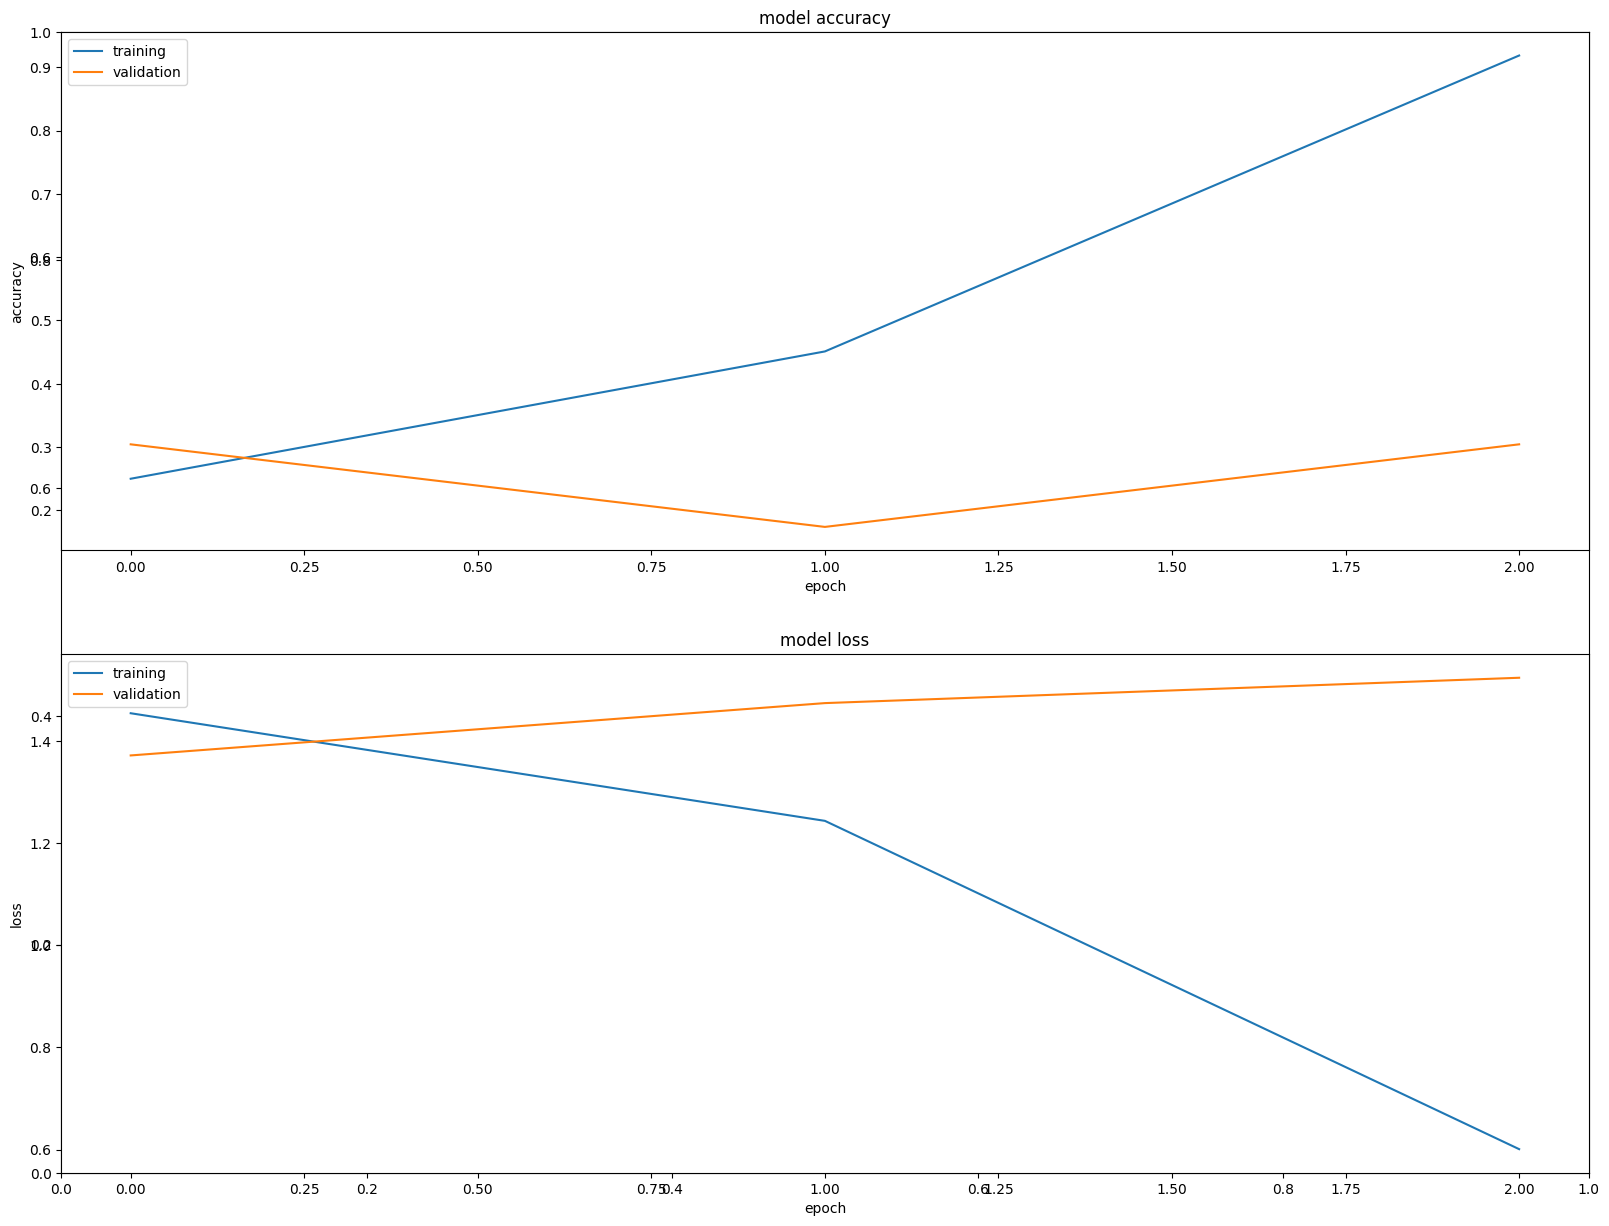

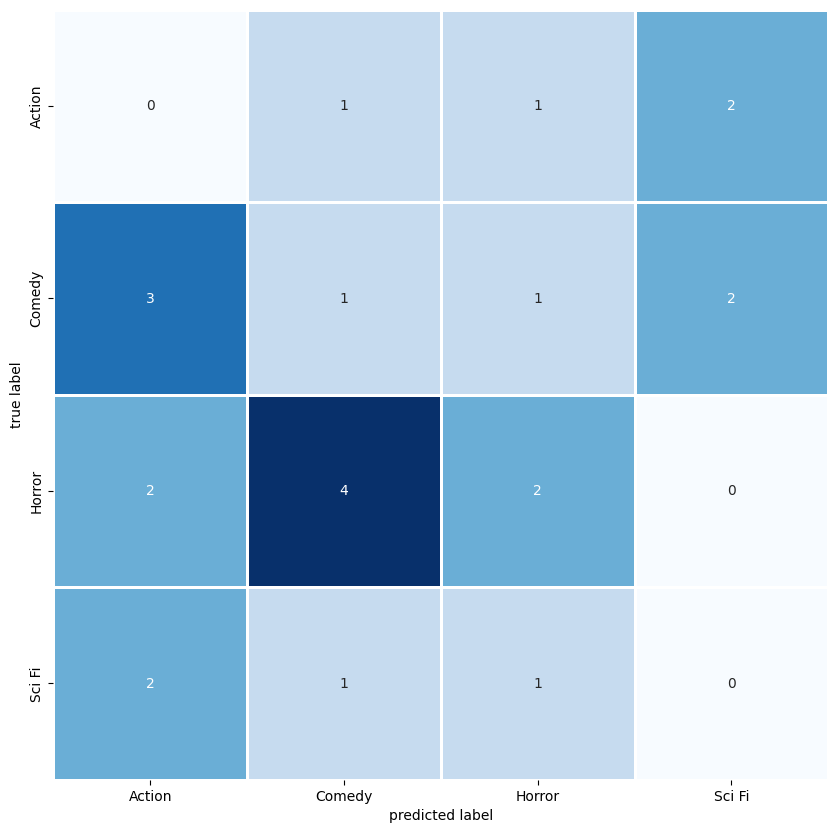

In [102]:
# RNN Model 3 (2 layers with 32 neurons)
k.clear_session()
num_classes = 4

model_rnn = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        mask_zero=True  # Use masking to handle variable sequence lengths
    ),
    tf.keras.layers.Bidirectional(tf.keras.layers.SimpleRNN(32,dropout=0.1, return_sequences=True)),  # Replaced LSTM with SimpleRNN
    tf.keras.layers.Bidirectional(tf.keras.layers.SimpleRNN(32,dropout=0.1)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(num_classes, activation='softmax')  # num_classes = 4
])

model_rnn.compile(optimizer= tf.keras.optimizers.Adam( )
                 ,loss=tf.keras.losses.SparseCategoricalCrossentropy()
                 ,metrics=['accuracy'])

history_rnn = model_rnn.fit(train_ds
             ,epochs=200
             ,validation_data=val_ds
             #,validation_steps=3
             ,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)])

test_loss, test_acc = model_rnn.evaluate(test_ds)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

history_rnn_dict = history_rnn.history
history_rnn_dict.keys()

history_rnn_df=pd.DataFrame(history_rnn_dict)
history_rnn_df.tail().round(3)

losses_rnn = history_rnn.history['loss']
accs_rnn = history_rnn.history['accuracy']
val_losses_rnn = history_rnn.history['val_loss']
val_accs_rnn = history_rnn.history['val_accuracy']
epochs_rnn = len(losses_rnn)

plt.subplots(figsize=(16,12))
plt.tight_layout()
display_training_curves(history_rnn.history['accuracy'], history_rnn.history['val_accuracy'], 'accuracy', 211)
display_training_curves(history_rnn.history['loss'], history_rnn.history['val_loss'], 'loss', 212)

preds2_rnn = model_rnn.predict(test_ds)
y_pred2_rnn = np.argmax(preds2_rnn, axis=1)
y2_rnn = np.concatenate([y for x, y in test_ds], axis=0)

CLASSES_LIST = ['Action','Comedy','Horror','Sci Fi']

plot_confusion_matrix_labeled(y2_rnn,y_pred2_rnn, CLASSES_LIST=CLASSES_LIST)

cm = sns.light_palette((260, 75, 60), input="husl", as_cmap=True)

df2_rnn = pd.DataFrame(preds2_rnn[0:15]
                  ,columns = CLASSES_LIST).T
df2_rnn.style.format("{:.2%}").background_gradient(cmap=cm)

Epoch 1/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 37s 427ms/step - accuracy: 0.2862 - loss: 1.4698 - val_accuracy: 0.3043 - val_loss: 1.4253
Epoch 2/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 25s 406ms/step - accuracy: 0.2604 - loss: 1.4058 - val_accuracy: 0.1304 - val_loss: 1.6434
Epoch 3/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 41s 403ms/step - accuracy: 0.2789 - loss: 1.3879 - val_accuracy: 0.1739 - val_loss: 1.4691
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.0361 - loss: 1.6666
Test Loss: 1.7243553400039673
Test Accuracy: 0.08695652335882187


8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 166ms/step


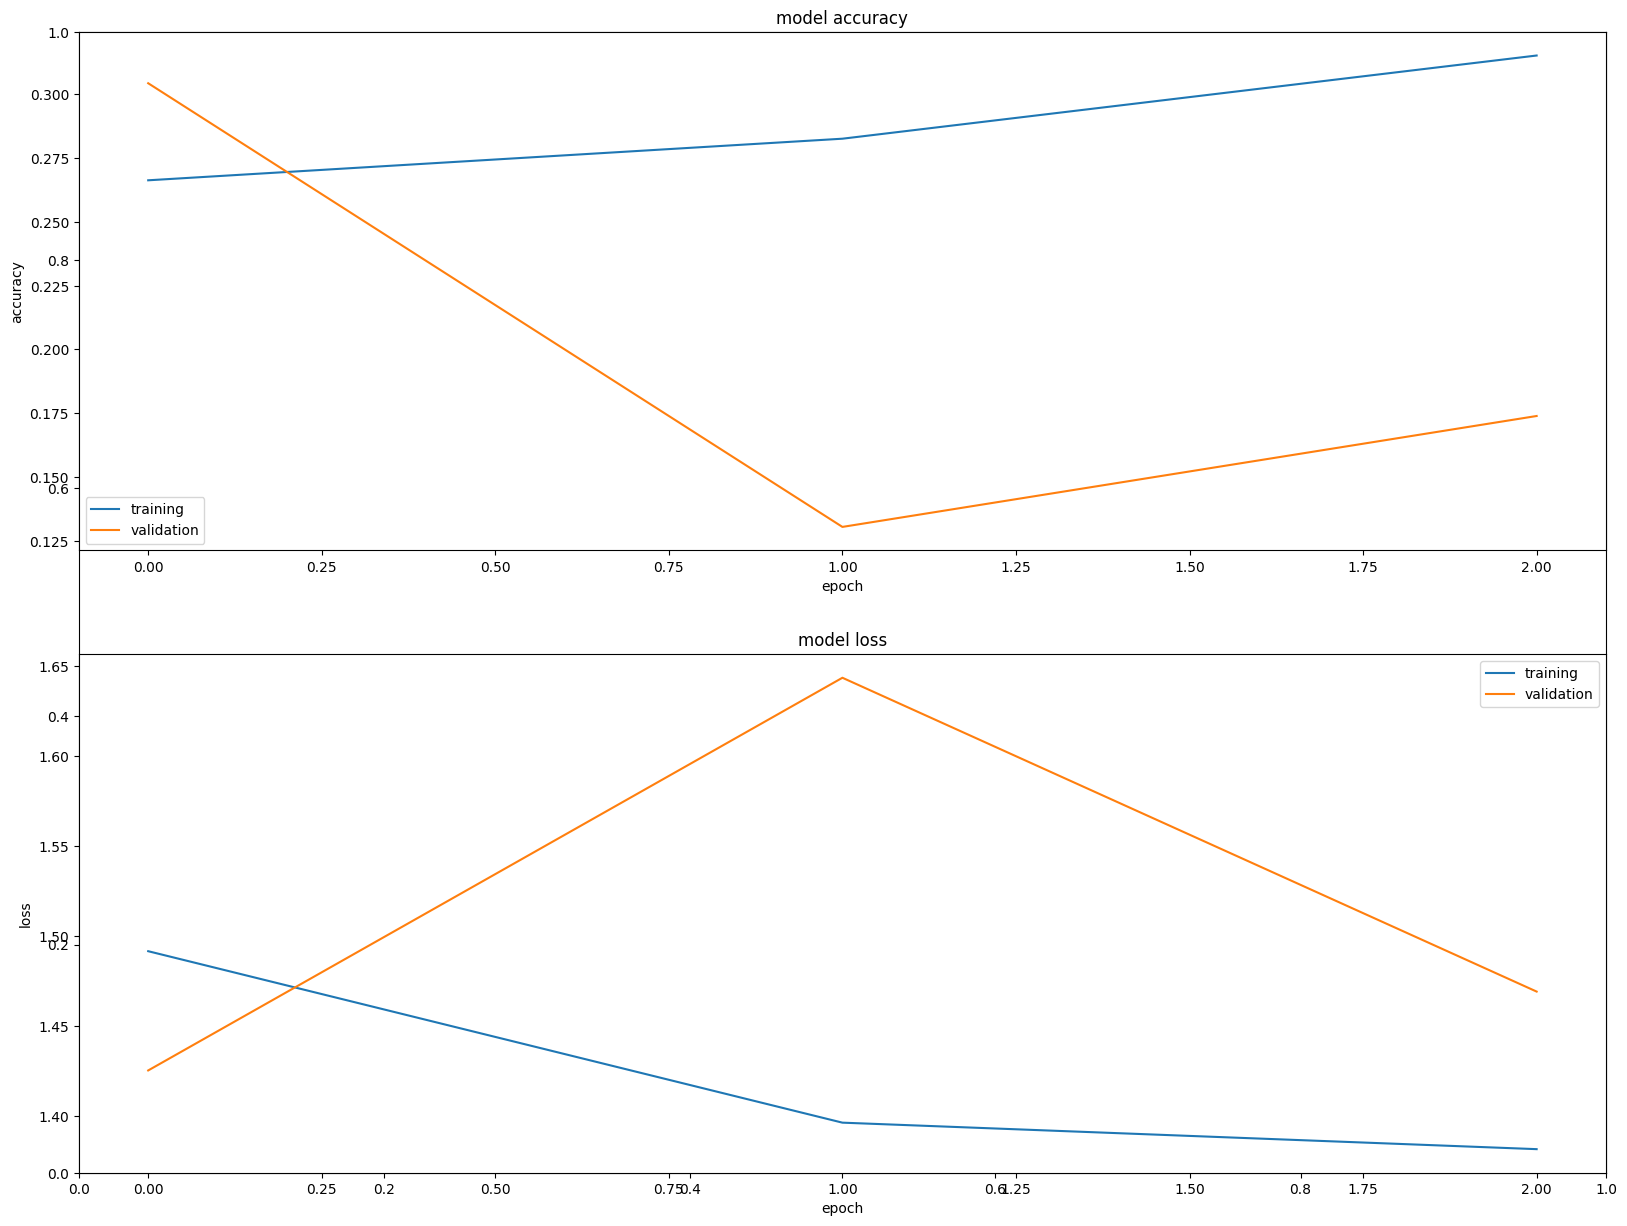

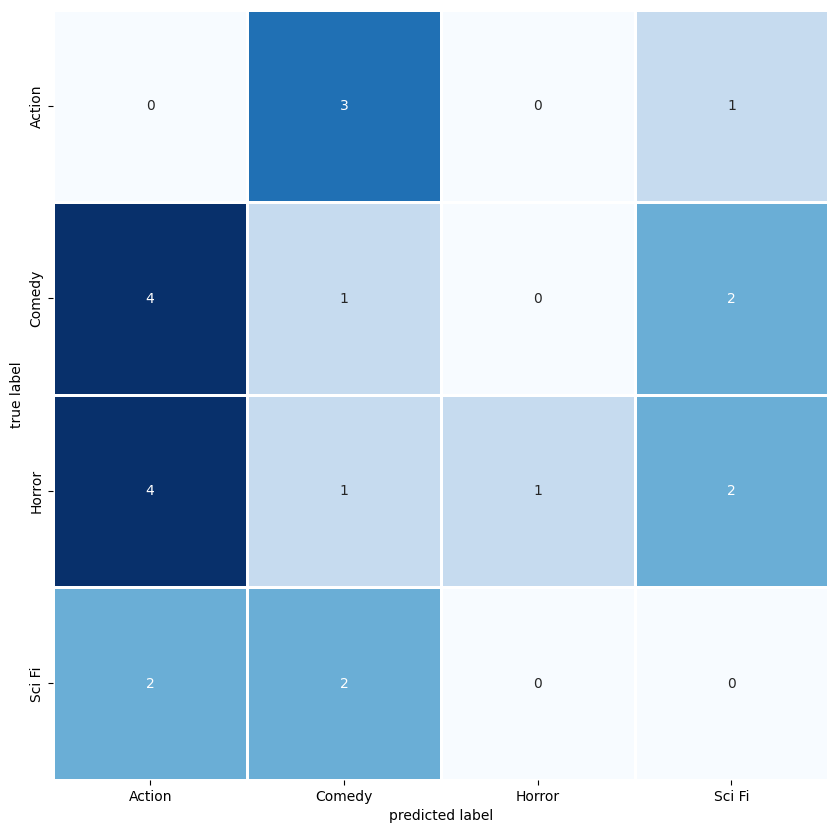

In [103]:
# RNN Model 4 (2 layers with 64 neurons)
k.clear_session()
num_classes = 4

model_rnn = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        mask_zero=True  # Use masking to handle variable sequence lengths
    ),
    tf.keras.layers.Bidirectional(tf.keras.layers.SimpleRNN(64,dropout=0.1, return_sequences=True)),  # Replaced LSTM with SimpleRNN
    tf.keras.layers.Bidirectional(tf.keras.layers.SimpleRNN(64,dropout=0.1)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(num_classes, activation='softmax')  # num_classes = 4
])

model_rnn.compile(optimizer= tf.keras.optimizers.Adam( )
                 ,loss=tf.keras.losses.SparseCategoricalCrossentropy()
                 ,metrics=['accuracy'])

history_rnn = model_rnn.fit(train_ds
             ,epochs=200
             ,validation_data=val_ds
             #,validation_steps=3
             ,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)])

test_loss, test_acc = model_rnn.evaluate(test_ds)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

history_rnn_dict = history_rnn.history
history_rnn_dict.keys()

history_rnn_df=pd.DataFrame(history_rnn_dict)
history_rnn_df.tail().round(3)

losses_rnn = history_rnn.history['loss']
accs_rnn = history_rnn.history['accuracy']
val_losses_rnn = history_rnn.history['val_loss']
val_accs_rnn = history_rnn.history['val_accuracy']
epochs_rnn = len(losses_rnn)

plt.subplots(figsize=(16,12))
plt.tight_layout()
display_training_curves(history_rnn.history['accuracy'], history_rnn.history['val_accuracy'], 'accuracy', 211)
display_training_curves(history_rnn.history['loss'], history_rnn.history['val_loss'], 'loss', 212)

preds2_rnn = model_rnn.predict(test_ds)
y_pred2_rnn = np.argmax(preds2_rnn, axis=1)
y2_rnn = np.concatenate([y for x, y in test_ds], axis=0)

CLASSES_LIST = ['Action','Comedy','Horror','Sci Fi']

plot_confusion_matrix_labeled(y2_rnn,y_pred2_rnn, CLASSES_LIST=CLASSES_LIST)

cm = sns.light_palette((260, 75, 60), input="husl", as_cmap=True)

df2_rnn = pd.DataFrame(preds2_rnn[0:15]
                  ,columns = CLASSES_LIST).T
df2_rnn.style.format("{:.2%}").background_gradient(cmap=cm)

## Build LSTM Sequential Model

<div class="alert alert-block alert-info">
    <b>tf.keras.layers</b><br>
    https://www.tensorflow.org/api_docs/python/tf/keras/layers
    </div>

In [104]:
# LSTM Model 1 (1 layer with 32 neurons)
k.clear_session()
num_classes=4
model_lstm=tf.keras.Sequential([encoder
   ,tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True)
   ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32,dropout=0.3))
   ,tf.keras.layers.Dense(64, activation='relu')
   ,tf.keras.layers.Dense(num_classes,activation='softmax')
])

In [105]:
model_lstm.compile(optimizer= tf.keras.optimizers.Adam( )
                   ,loss=tf.keras.losses.SparseCategoricalCrossentropy()
                   ,metrics=['accuracy'])

In [106]:
%%time
history_lstm = model_lstm.fit(train_ds
         ,epochs=200
         ,validation_data=val_ds
         #,validation_steps=3
         ,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)])

Epoch 1/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 26s 300ms/step - accuracy: 0.2139 - loss: 1.3881 - val_accuracy: 0.3913 - val_loss: 1.3765
Epoch 2/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 20s 289ms/step - accuracy: 0.6726 - loss: 1.3418 - val_accuracy: 0.4783 - val_loss: 1.3840
Epoch 3/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 18s 285ms/step - accuracy: 0.4872 - loss: 1.1718 - val_accuracy: 0.9130 - val_loss: 0.6519
Epoch 4/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 21s 289ms/step - accuracy: 0.8815 - loss: 0.4110 - val_accuracy: 0.7391 - val_loss: 0.5823
Epoch 5/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 18s 296ms/step - accuracy: 0.9880 - loss: 0.0852 - val_accuracy: 0.7826 - val_loss: 0.6458
CPU times: user 2min 42s, sys: 1.91 s, total: 2min 44s
Wall time: 1min 42s


## Model Performance Test Accuracy - LSTM

In [107]:
test_loss_lstm, test_acc_lstm = model_lstm.evaluate(test_ds)

print('Test Loss: {}'.format(test_loss_lstm))
print('Test Accuracy: {}'.format(test_acc_lstm))

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 0.5711 - loss: 0.8199
Test Loss: 0.7101783156394958
Test Accuracy: 0.6521739363670349


## Plotting Performance Metrics - Multi-Layer Bidirectional LSTM

In [108]:
history_lstm_dict = history_lstm.history
history_lstm_dict.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [109]:
history_lstm_df=pd.DataFrame(history_lstm_dict)
history_lstm_df.tail().round(3)

accuracy   loss  val_accuracy  val_loss
0     0.272  1.387         0.391     1.377
1     0.603  1.330         0.478     1.384
2     0.690  0.899         0.913     0.652
3     0.913  0.340         0.739     0.582
4     0.989  0.066         0.783     0.646

In [110]:
losses_lstm = history_lstm.history['loss']
accs_lstm = history_lstm.history['accuracy']
val_losses_lstm = history_lstm.history['val_loss']
val_accs_lstm = history_lstm.history['val_accuracy']
epochs_lstm = len(losses_lstm)

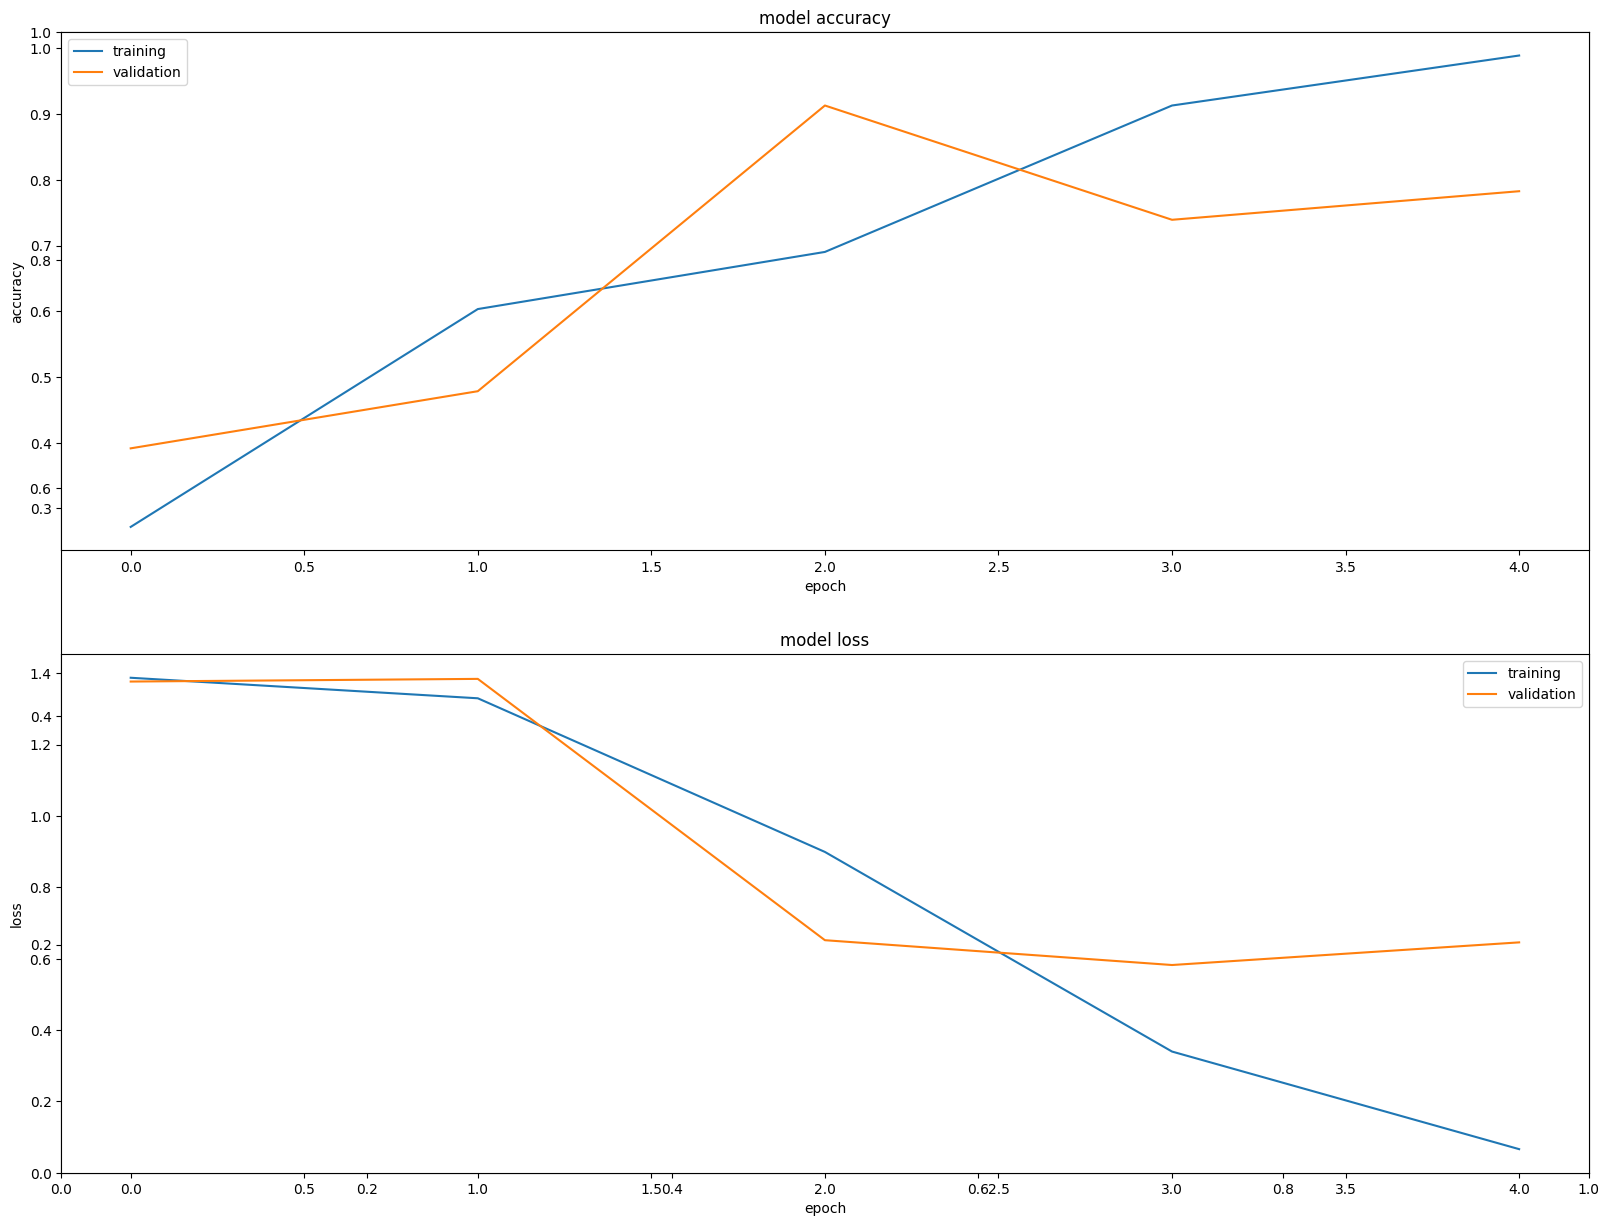

In [111]:
plt.subplots(figsize=(16,12))
plt.tight_layout()
display_training_curves(history_lstm.history['accuracy'], history_lstm.history['val_accuracy'], 'accuracy', 211)
display_training_curves(history_lstm.history['loss'], history_lstm.history['val_loss'], 'loss', 212)

## Confusion Matrix Post Model Performance Analysis - LSTM

In [112]:
preds2_lstm = model_lstm.predict(test_ds)
y_pred2_lstm = np.argmax(preds2_lstm, axis=1)
y2_lstm = np.concatenate([y for x, y in test_ds], axis=0)

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step


In [113]:
CLASSES_LIST = ['Action','Comedy','Horror','Sci Fi']

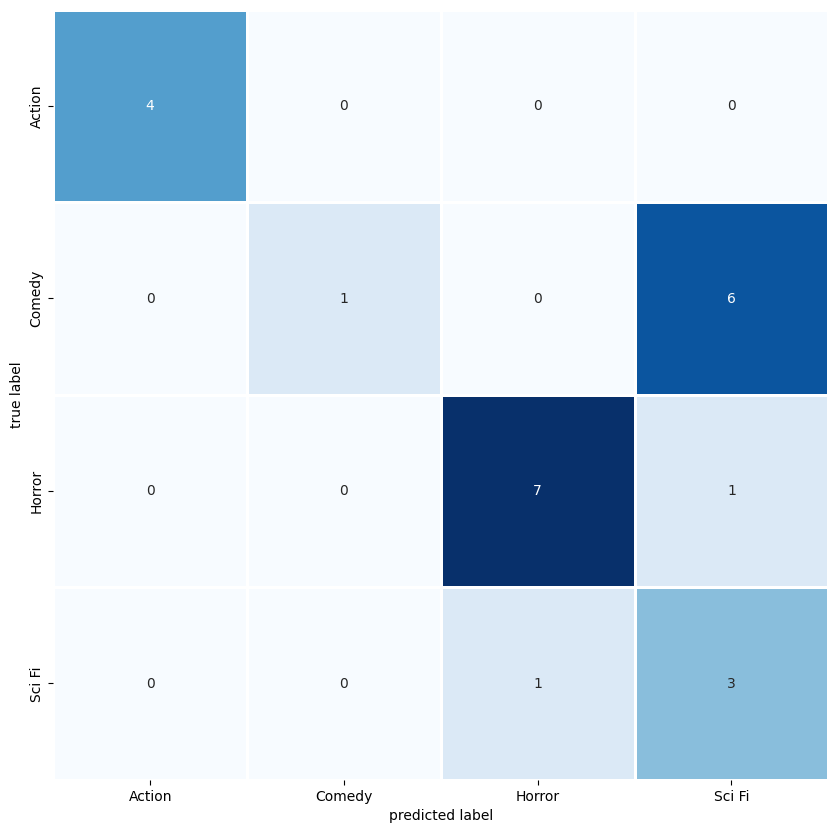

In [114]:
plot_confusion_matrix_labeled(y2_lstm,y_pred2_lstm, CLASSES_LIST=CLASSES_LIST)

In [115]:
cm = sns.light_palette((260, 75, 60), input="husl", as_cmap=True)

In [116]:
df2_lstm = pd.DataFrame(preds2_lstm[0:15]
                  ,columns = CLASSES_LIST).T
df2_lstm.style.format("{:.2%}").background_gradient(cmap=cm)

## LSTM Model Architecture

In [117]:
model_lstm.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization              │ (None, None)           │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, None, 64)       │       320,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 64)             │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,047,758 (4.00 MB)

 Trainable params: 349,252 (1.33 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 698,506 (2.66 MB)

Epoch 1/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 27s 347ms/step - accuracy: 0.2880 - loss: 1.3858 - val_accuracy: 0.2174 - val_loss: 1.3857
Epoch 2/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 20s 320ms/step - accuracy: 0.5036 - loss: 1.3177 - val_accuracy: 0.4783 - val_loss: 1.1597
Epoch 3/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 21s 330ms/step - accuracy: 0.8053 - loss: 0.7465 - val_accuracy: 0.5652 - val_loss: 1.1281
Epoch 4/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 40s 318ms/step - accuracy: 0.9601 - loss: 0.1322 - val_accuracy: 0.6957 - val_loss: 1.0175
Epoch 5/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 22s 335ms/step - accuracy: 1.0000 - loss: 0.0087 - val_accuracy: 0.7391 - val_loss: 0.7122
Epoch 6/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 20s 329ms/step - accuracy: 1.0000 - loss: 0.0023 - val_accuracy: 0.7391 - val_loss: 0.7495
Epoch 7/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 20s 317ms/step - accuracy: 1.0000 - loss: 0.0011 - val_accuracy: 0.6957 - val_loss: 0.8290
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.5154 - loss: 1.5805
Test Loss: 1.33667

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization              │ (None, None)           │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, None, 64)       │       320,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 128)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,183,694 (4.52 MB)

 Trainable params: 394,564 (1.51 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 789,130 (3.01 MB)

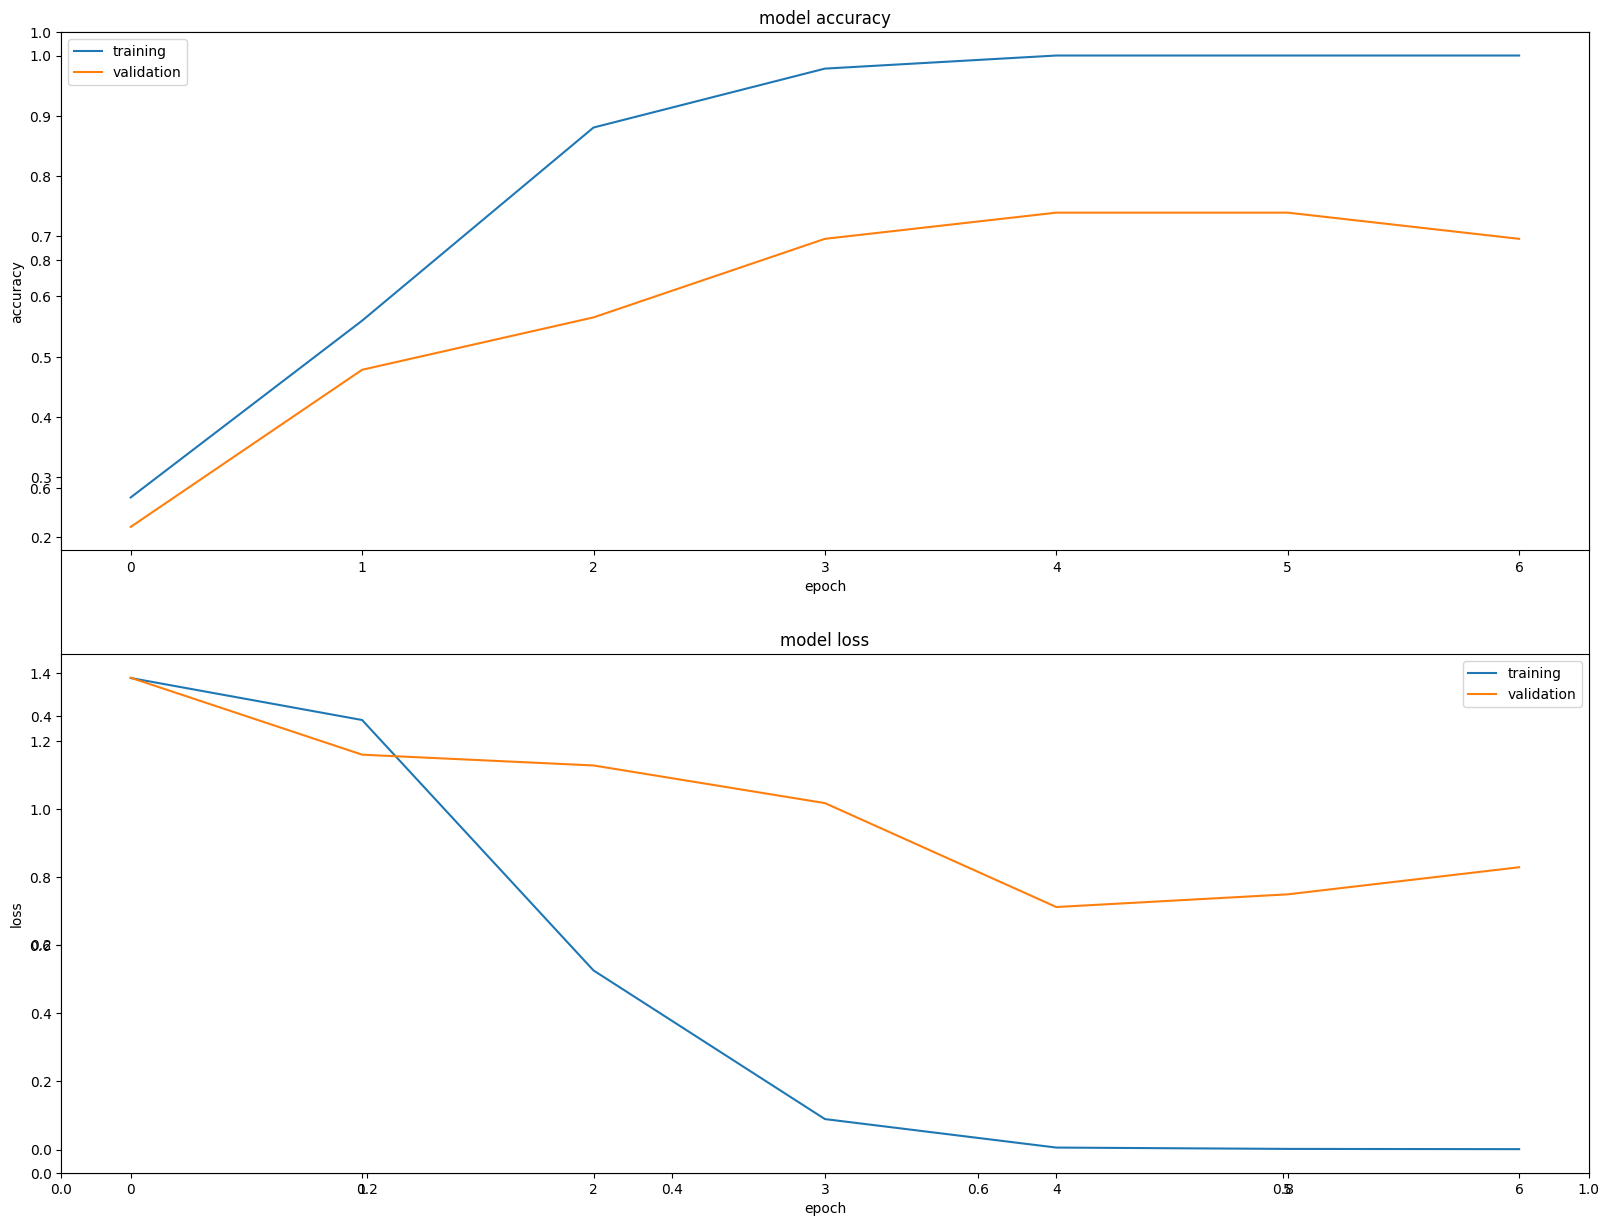

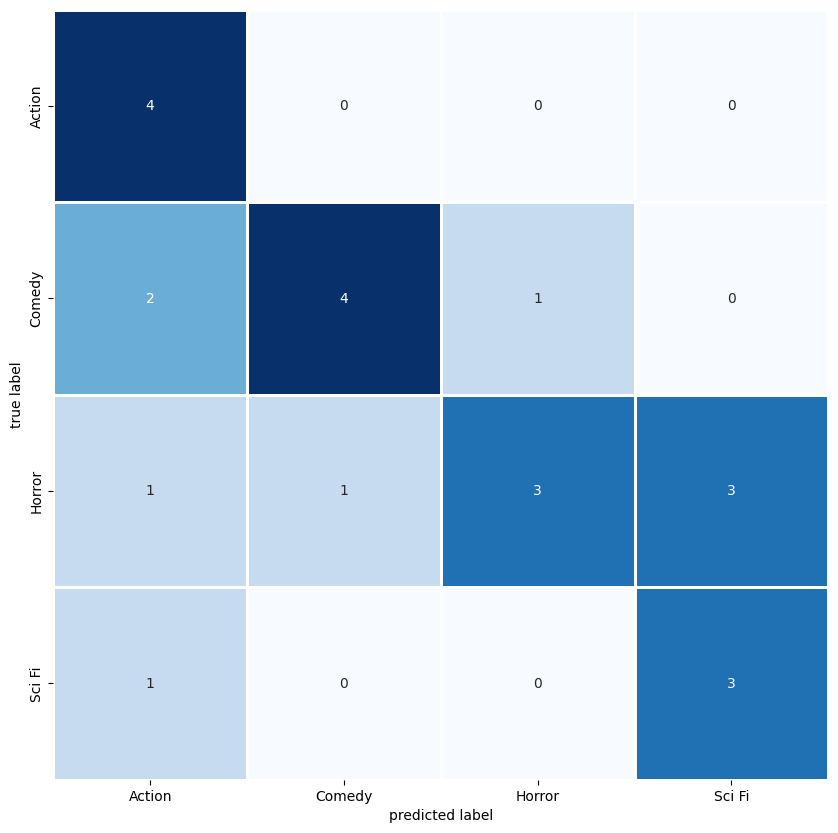

In [118]:
# LSTM Model 2 (1 layer with 64 neurons)
k.clear_session()
num_classes=4
model_lstm=tf.keras.Sequential([encoder
   ,tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True)
   ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,dropout=0.3))
   ,tf.keras.layers.Dense(64, activation='relu')
   ,tf.keras.layers.Dense(num_classes,activation='softmax')
])

model_lstm.compile(optimizer= tf.keras.optimizers.Adam( )
                   ,loss=tf.keras.losses.SparseCategoricalCrossentropy()
                   ,metrics=['accuracy'])

history_lstm = model_lstm.fit(train_ds
         ,epochs=200
         ,validation_data=val_ds
         #,validation_steps=3
         ,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)])

test_loss_lstm, test_acc_lstm = model_lstm.evaluate(test_ds)

print('Test Loss: {}'.format(test_loss_lstm))
print('Test Accuracy: {}'.format(test_acc_lstm))

history_lstm_dict = history_lstm.history
history_lstm_dict.keys()

history_lstm_df=pd.DataFrame(history_lstm_dict)
history_lstm_df.tail().round(3)

losses_lstm = history_lstm.history['loss']
accs_lstm = history_lstm.history['accuracy']
val_losses_lstm = history_lstm.history['val_loss']
val_accs_lstm = history_lstm.history['val_accuracy']
epochs_lstm = len(losses_lstm)

plt.subplots(figsize=(16,12))
plt.tight_layout()
display_training_curves(history_lstm.history['accuracy'], history_lstm.history['val_accuracy'], 'accuracy', 211)
display_training_curves(history_lstm.history['loss'], history_lstm.history['val_loss'], 'loss', 212)

preds2_lstm = model_lstm.predict(test_ds)
y_pred2_lstm = np.argmax(preds2_lstm, axis=1)
y2_lstm = np.concatenate([y for x, y in test_ds], axis=0)

CLASSES_LIST = ['Action','Comedy','Horror','Sci Fi']

plot_confusion_matrix_labeled(y2_lstm,y_pred2_lstm, CLASSES_LIST=CLASSES_LIST)

cm = sns.light_palette((260, 75, 60), input="husl", as_cmap=True)

df2_lstm = pd.DataFrame(preds2_lstm[0:15]
                  ,columns = CLASSES_LIST).T
df2_lstm.style.format("{:.2%}").background_gradient(cmap=cm)

model_lstm.summary()

Epoch 1/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 49s 595ms/step - accuracy: 0.2858 - loss: 1.3870 - val_accuracy: 0.1304 - val_loss: 1.3977
Epoch 2/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 36s 578ms/step - accuracy: 0.3195 - loss: 1.3386 - val_accuracy: 0.4783 - val_loss: 1.0487
Epoch 3/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 36s 587ms/step - accuracy: 0.7843 - loss: 0.7168 - val_accuracy: 0.7391 - val_loss: 0.7191
Epoch 4/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 36s 579ms/step - accuracy: 0.9235 - loss: 0.2114 - val_accuracy: 0.7391 - val_loss: 0.5286
Epoch 5/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 41s 579ms/step - accuracy: 0.9772 - loss: 0.0913 - val_accuracy: 0.6957 - val_loss: 0.8781
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 0.7560 - loss: 0.6452
Test Loss: 0.6343591809272766
Test Accuracy: 0.739130437374115
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 219ms/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization              │ (None, None)           │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, None, 64)       │       320,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, None, 64)       │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 64)             │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,122,254 (4.28 MB)

 Trainable params: 374,084 (1.43 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 748,170 (2.85 MB)

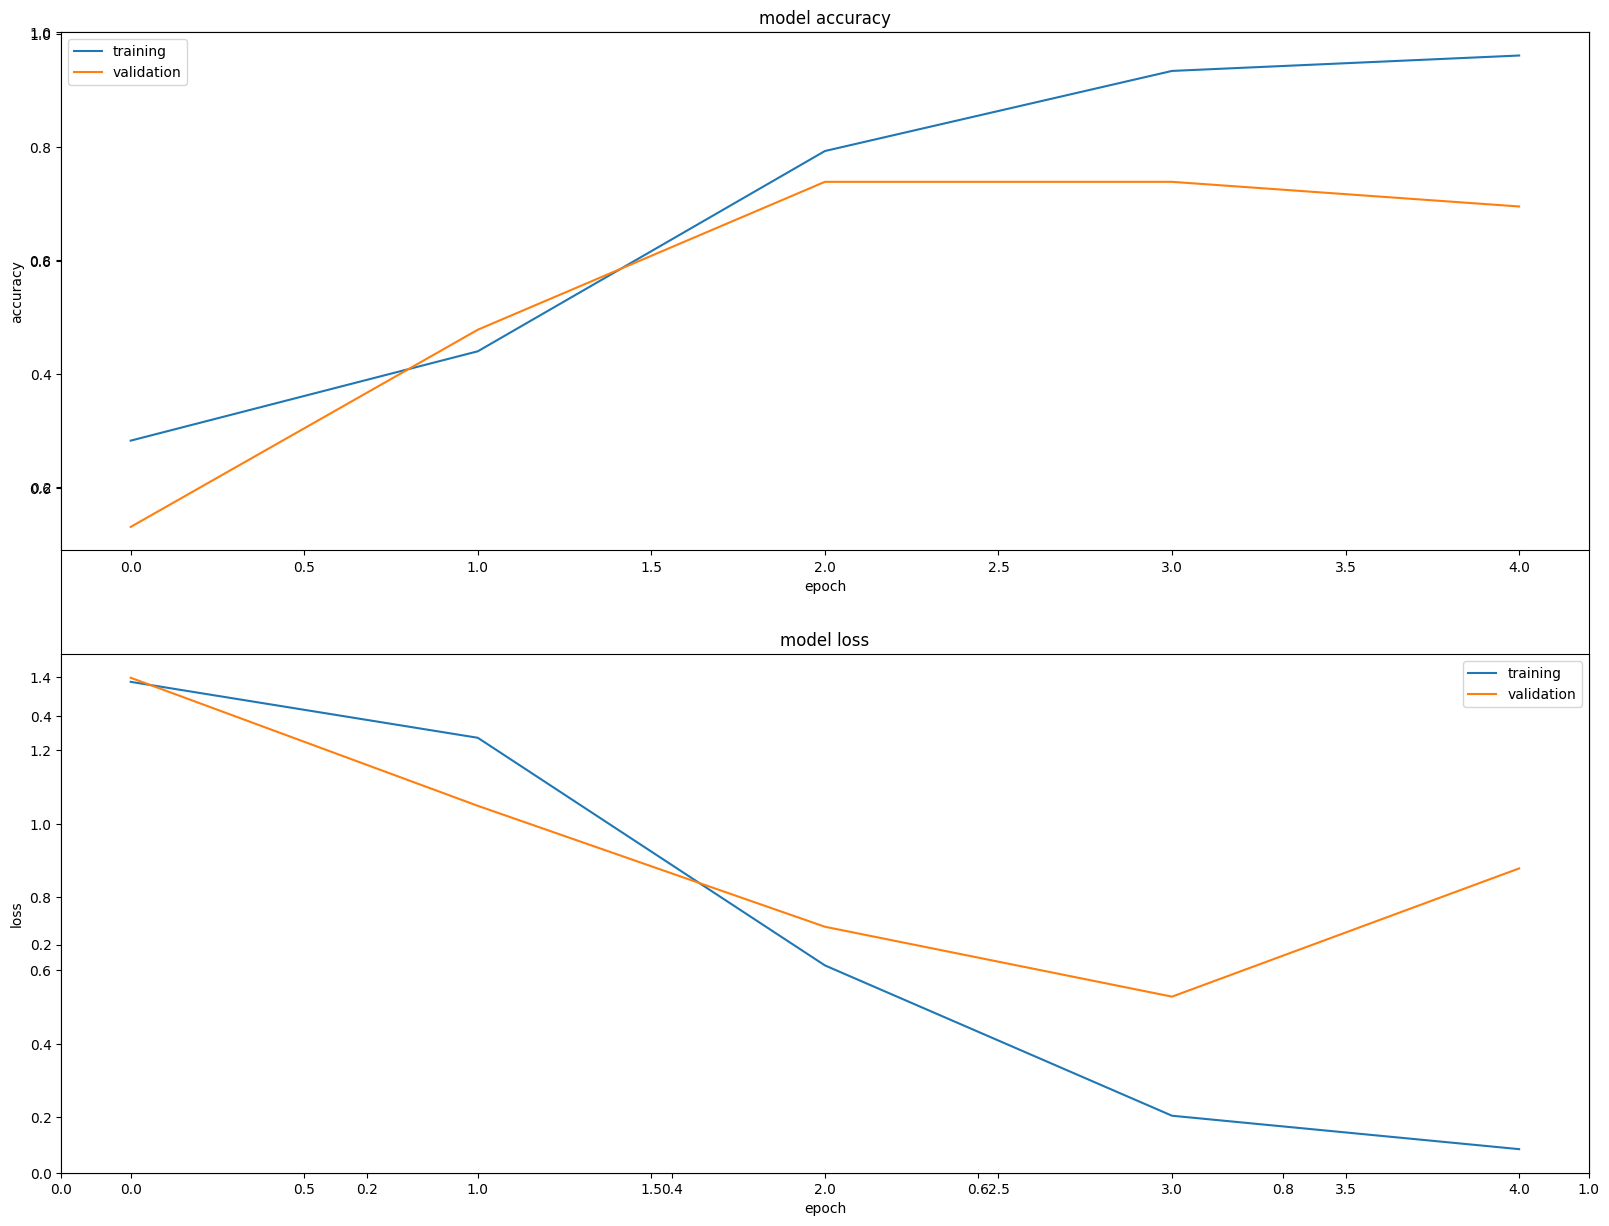

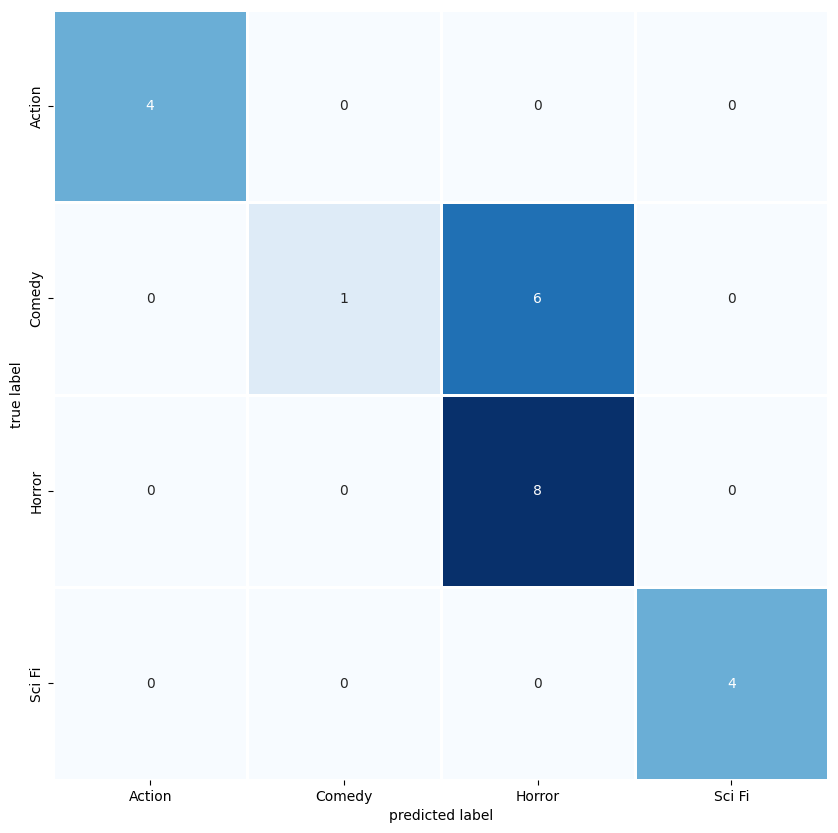

In [119]:
# LSTM Model 3 (2 layer with 32 neurons)
k.clear_session()
num_classes=4
model_lstm=tf.keras.Sequential([encoder
   ,tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True)
   ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32,  return_sequences=True, dropout=0.3))
   ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32,dropout=0.3))
   ,tf.keras.layers.Dense(64, activation='relu')
   ,tf.keras.layers.Dense(num_classes,activation='softmax')
])

model_lstm.compile(optimizer= tf.keras.optimizers.Adam( )
                   ,loss=tf.keras.losses.SparseCategoricalCrossentropy()
                   ,metrics=['accuracy'])

history_lstm = model_lstm.fit(train_ds
         ,epochs=200
         ,validation_data=val_ds
         #,validation_steps=3
         ,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)])

test_loss_lstm, test_acc_lstm = model_lstm.evaluate(test_ds)

print('Test Loss: {}'.format(test_loss_lstm))
print('Test Accuracy: {}'.format(test_acc_lstm))

history_lstm_dict = history_lstm.history
history_lstm_dict.keys()

history_lstm_df=pd.DataFrame(history_lstm_dict)
history_lstm_df.tail().round(3)

losses_lstm = history_lstm.history['loss']
accs_lstm = history_lstm.history['accuracy']
val_losses_lstm = history_lstm.history['val_loss']
val_accs_lstm = history_lstm.history['val_accuracy']
epochs_lstm = len(losses_lstm)

plt.subplots(figsize=(16,12))
plt.tight_layout()
display_training_curves(history_lstm.history['accuracy'], history_lstm.history['val_accuracy'], 'accuracy', 211)
display_training_curves(history_lstm.history['loss'], history_lstm.history['val_loss'], 'loss', 212)

preds2_lstm = model_lstm.predict(test_ds)
y_pred2_lstm = np.argmax(preds2_lstm, axis=1)
y2_lstm = np.concatenate([y for x, y in test_ds], axis=0)

CLASSES_LIST = ['Action','Comedy','Horror','Sci Fi']

plot_confusion_matrix_labeled(y2_lstm,y_pred2_lstm, CLASSES_LIST=CLASSES_LIST)

cm = sns.light_palette((260, 75, 60), input="husl", as_cmap=True)

df2_lstm = pd.DataFrame(preds2_lstm[0:15]
                  ,columns = CLASSES_LIST).T
df2_lstm.style.format("{:.2%}").background_gradient(cmap=cm)

model_lstm.summary()

Epoch 1/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 54s 690ms/step - accuracy: 0.2326 - loss: 1.3894 - val_accuracy: 0.1304 - val_loss: 1.4000
Epoch 2/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 81s 673ms/step - accuracy: 0.3243 - loss: 1.3413 - val_accuracy: 0.4783 - val_loss: 1.5101
Epoch 3/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 42s 673ms/step - accuracy: 0.5699 - loss: 0.9259 - val_accuracy: 0.6957 - val_loss: 0.8743
Epoch 4/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 43s 690ms/step - accuracy: 0.6404 - loss: 0.7485 - val_accuracy: 0.6957 - val_loss: 0.6474
Epoch 5/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 42s 677ms/step - accuracy: 0.7492 - loss: 0.4876 - val_accuracy: 0.7391 - val_loss: 1.0736
Epoch 6/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 42s 686ms/step - accuracy: 0.8355 - loss: 0.3819 - val_accuracy: 0.7391 - val_loss: 0.6271
Epoch 7/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 82s 683ms/step - accuracy: 0.9129 - loss: 0.2535 - val_accuracy: 0.7826 - val_loss: 0.8645
Epoch 8/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 42s 680ms/step - accuracy: 0.9575 - loss: 0.1351 - 

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization              │ (None, None)           │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, None, 64)       │       320,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, None, 128)      │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,480,142 (5.65 MB)

 Trainable params: 493,380 (1.88 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 986,762 (3.76 MB)

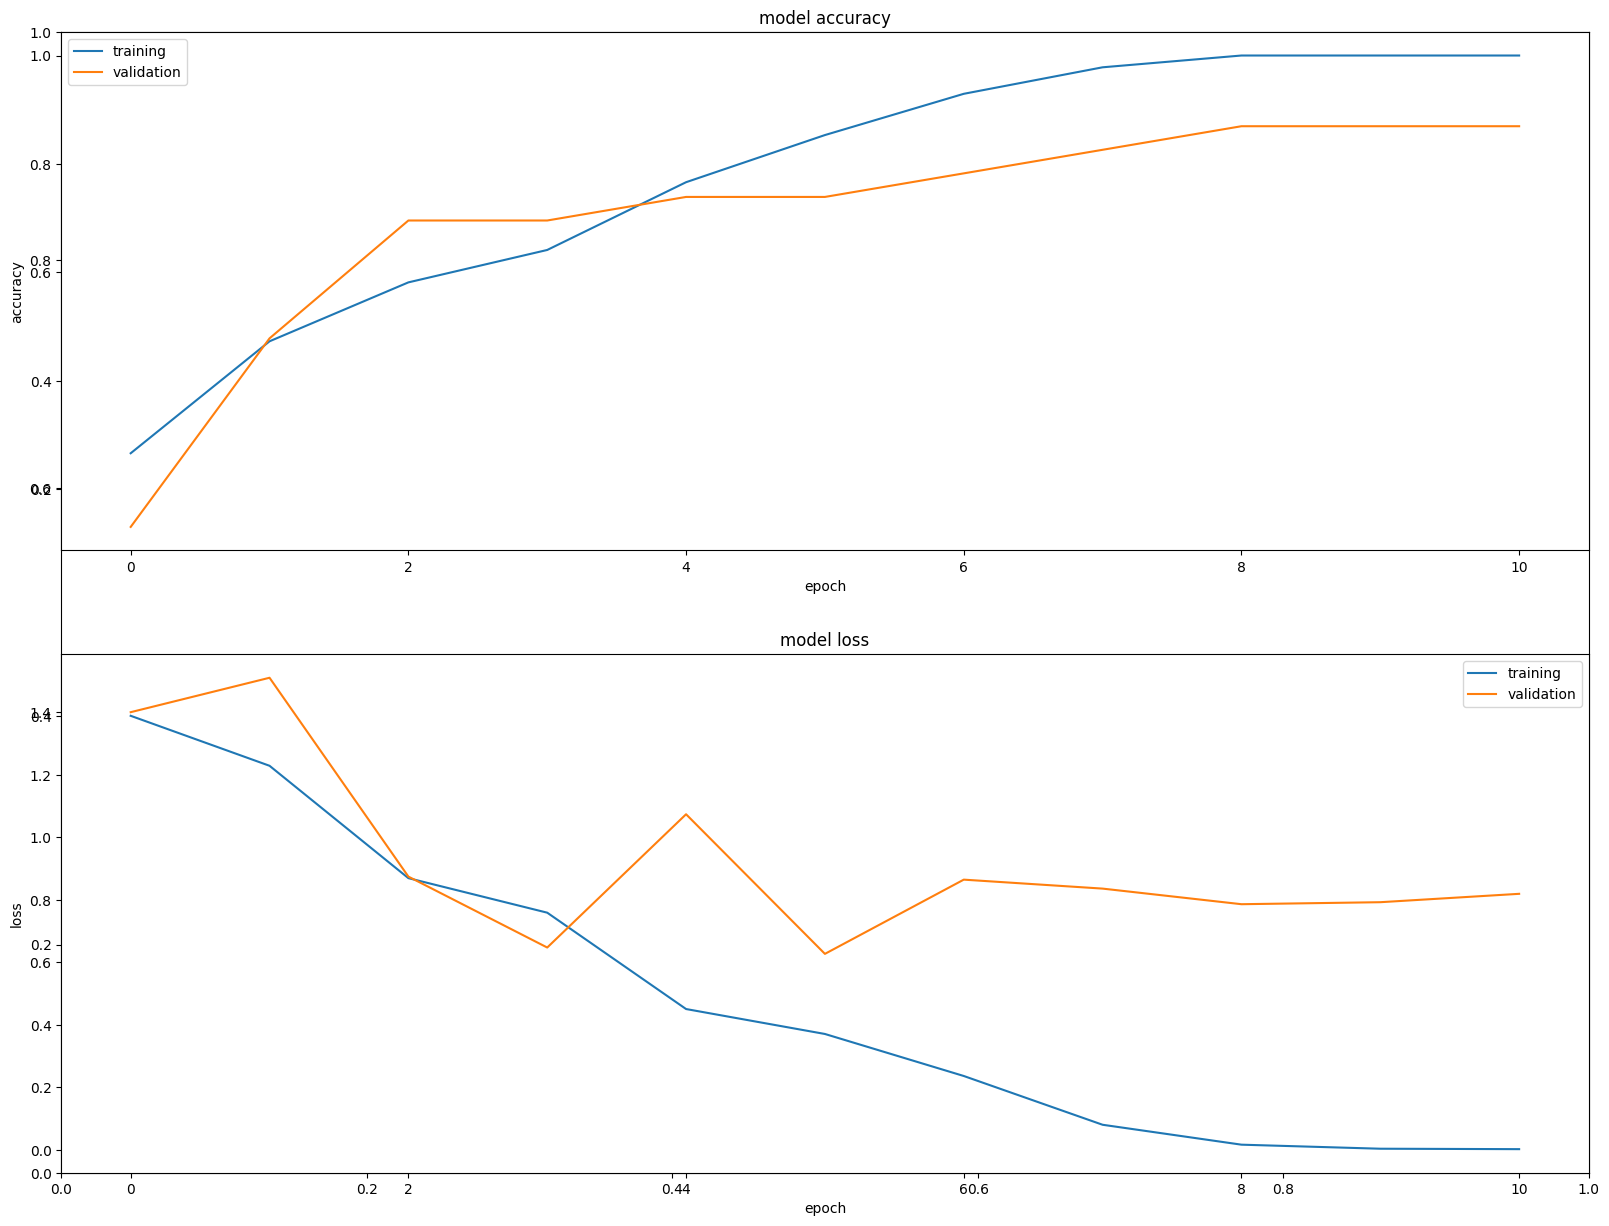

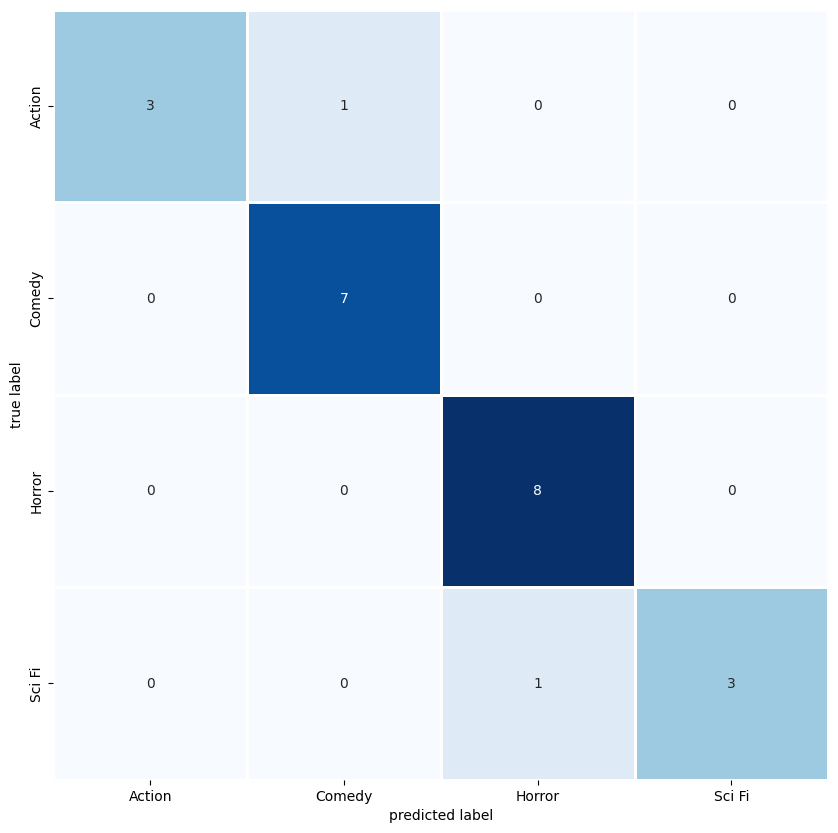

In [120]:
# LSTM Model 4 (2 layer with 64 neurons)
k.clear_session()
num_classes=4
model_lstm=tf.keras.Sequential([encoder
   ,tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True)
   ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True, dropout=0.3))
   ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,dropout=0.3))
   ,tf.keras.layers.Dense(64, activation='relu')
   ,tf.keras.layers.Dense(num_classes,activation='softmax')
])

model_lstm.compile(optimizer= tf.keras.optimizers.Adam( )
                   ,loss=tf.keras.losses.SparseCategoricalCrossentropy()
                   ,metrics=['accuracy'])

history_lstm = model_lstm.fit(train_ds
         ,epochs=200
         ,validation_data=val_ds
         #,validation_steps=3
         ,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)])

test_loss_lstm, test_acc_lstm = model_lstm.evaluate(test_ds)

print('Test Loss: {}'.format(test_loss_lstm))
print('Test Accuracy: {}'.format(test_acc_lstm))

history_lstm_dict = history_lstm.history
history_lstm_dict.keys()

history_lstm_df=pd.DataFrame(history_lstm_dict)
history_lstm_df.tail().round(3)

losses_lstm = history_lstm.history['loss']
accs_lstm = history_lstm.history['accuracy']
val_losses_lstm = history_lstm.history['val_loss']
val_accs_lstm = history_lstm.history['val_accuracy']
epochs_lstm = len(losses_lstm)

plt.subplots(figsize=(16,12))
plt.tight_layout()
display_training_curves(history_lstm.history['accuracy'], history_lstm.history['val_accuracy'], 'accuracy', 211)
display_training_curves(history_lstm.history['loss'], history_lstm.history['val_loss'], 'loss', 212)

preds2_lstm = model_lstm.predict(test_ds)
y_pred2_lstm = np.argmax(preds2_lstm, axis=1)
y2_lstm = np.concatenate([y for x, y in test_ds], axis=0)

CLASSES_LIST = ['Action','Comedy','Horror','Sci Fi']

plot_confusion_matrix_labeled(y2_lstm,y_pred2_lstm, CLASSES_LIST=CLASSES_LIST)

cm = sns.light_palette((260, 75, 60), input="husl", as_cmap=True)

df2_lstm = pd.DataFrame(preds2_lstm[0:15]
                  ,columns = CLASSES_LIST).T
df2_lstm.style.format("{:.2%}").background_gradient(cmap=cm)

model_lstm.summary()

In [121]:
#########################################
# Final Packaging Checklist for TA
#########################################

# Restore QA class corpus URL
# Delete OpenAI key
# Put sleep back to 10 seconds
# comment out openai experimental code
# fix Dirty_Grandpa vs Dirty Grandpa spelling difference

In [122]:
!pip list

Package                               Version
------------------------------------- -------------------
absl-py                               1.4.0
accelerate                            1.6.0
aiohappyeyeballs                      2.6.1
aiohttp                               3.11.15
aiosignal                             1.3.2
alabaster                             1.0.0
albucore                              0.0.24
albumentations                        2.0.6
ale-py                                0.11.0
altair                                5.5.0
annotated-types                       0.7.0
antlr4-python3-runtime                4.9.3
anyio                                 4.9.0
argon2-cffi                           23.1.0
argon2-cffi-bindings                  21.2.0
array_record                          0.7.2
arviz                                 0.21.0
astropy                               7.0.2
astropy-iers-data                     0.2025.5.12.0.38.29
astunparse                            1

In [123]:
!pip freeze

absl-py==1.4.0
accelerate==1.6.0
aiohappyeyeballs==2.6.1
aiohttp==3.11.15
aiosignal==1.3.2
alabaster==1.0.0
albucore==0.0.24
albumentations==2.0.6
ale-py==0.11.0
altair==5.5.0
annotated-types==0.7.0
antlr4-python3-runtime==4.9.3
anyio==4.9.0
argon2-cffi==23.1.0
argon2-cffi-bindings==21.2.0
array_record==0.7.2
arviz==0.21.0
astropy==7.0.2
astropy-iers-data==0.2025.5.12.0.38.29
astunparse==1.6.3
atpublic==5.1
attrs==25.3.0
audioread==3.0.1
autograd==1.8.0
babel==2.17.0
backcall==0.2.0
backports.tarfile==1.2.0
beautifulsoup4==4.13.4
betterproto==2.0.0b6
bigframes==2.4.0
bigquery-magics==0.9.0
bleach==6.2.0
blinker==1.9.0
blis==1.3.0
blobfile==3.0.0
blosc2==3.3.2
bokeh==3.7.3
Bottleneck==1.4.2
bqplot==0.12.44
branca==0.8.1
build==1.2.2.post1
CacheControl==0.14.3
cachetools==5.5.2
catalogue==2.0.10
certifi==2025.4.26
cffi==1.17.1
chardet==5.2.0
charset-normalizer==3.4.2
chex==0.1.89
clarabel==0.10.0
click==8.2.0
cloudpathlib==0.21.0
cloudpickle==3.1.1
cmake==3.31.6
cmdstanpy==1.2.5
colorcet